# Chapter 7: Pasture Biomass Prediction from Images

Deep learning and machine learning models for predicting pasture biomass from image data.

## Notebook Sections

1. **NEWEST VERSION** - Main prediction pipeline (Parts 1-4)
2. **Feature Importance Analysis** - Model interpretability
3. **Seasonal and Regional Analysis** - Performance by season/region
4. **Distribution of Biomass** - Data distribution analysis

## Data Requirements

- Image data directory: `data/images/`
- CSV files with biomass measurements
- Metadata files

## Repository

https://github.com/yourusername/thesis-dairy-optimisation/tree/main/chapter-7-biomass-prediction

## Note

File paths genericised for GitHub. Update `data/` paths to your local directories.


In [ ]:
# Required libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import cv2
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

print('Libraries imported successfully')


### Feature Importance Part

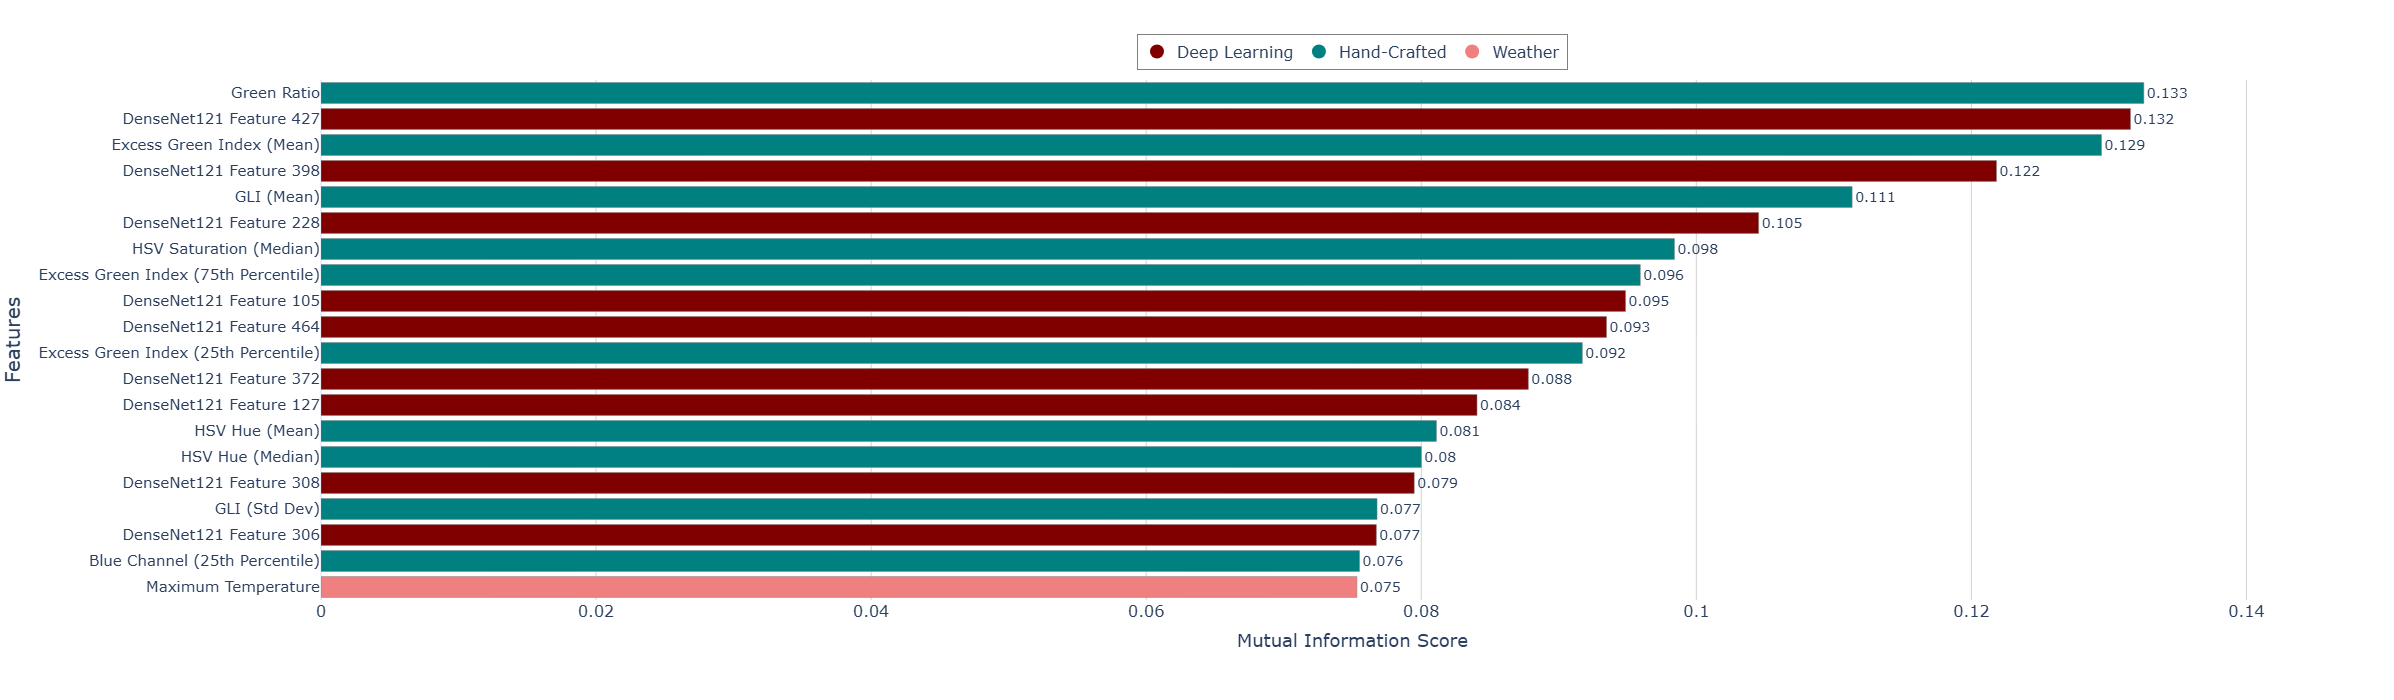

GENERATING FIGURE 2: FEATURE IMPORTANCE (REAL DATA)

✓ SVG saved: C:\Users\bnnen\OneDrive - The University of Sydney (Staff)\PHD Journey, Files and Thesis\PHD Documents\Papers\Paper 5\Results\figure2_feature_importance.svg
  High resolution with scale=20
  Dimensions: 1000x700 pixels (base) × 20 = 20000x14000 pixels

FEATURE IMPORTANCE SUMMARY (TOP 20)

MI Score range: 0.075321 to 0.132538

Feature type distribution in top 20:
  Hand-Crafted   : 10 features (50.0%)
  Deep Learning  :  9 features (45.0%)
  Weather        :  1 features ( 5.0%)

✓ FIGURE 2 COMPLETE
  - Readable feature names ✓
  - Larger fonts (axis labels: 18pt, ticks: 14-16pt, data labels: 14pt) ✓
  - Y-axis label 'Features' added ✓
  - Legend visible and styled ✓


In [41]:
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

# REAL data from exp17_feature_importance_top120.csv (Top 20)
# Map technical names to readable names
feature_name_mapping = {
    'green_ratio': 'Green Ratio',
    'DenseNet121_feat_427': 'DenseNet121 Feature 427',
    'excess_green_mean': 'Excess Green Index (Mean)',
    'DenseNet121_feat_398': 'DenseNet121 Feature 398',
    'gli_mean': 'GLI (Mean)',
    'DenseNet121_feat_228': 'DenseNet121 Feature 228',
    'S_median': 'HSV Saturation (Median)',
    'excess_green_q75': 'Excess Green Index (75th Percentile)',
    'DenseNet121_feat_105': 'DenseNet121 Feature 105',
    'DenseNet121_feat_464': 'DenseNet121 Feature 464',
    'excess_green_q25': 'Excess Green Index (25th Percentile)',
    'DenseNet121_feat_372': 'DenseNet121 Feature 372',
    'DenseNet121_feat_127': 'DenseNet121 Feature 127',
    'H_mean': 'HSV Hue (Mean)',
    'H_median': 'HSV Hue (Median)',
    'DenseNet121_feat_308': 'DenseNet121 Feature 308',
    'gli_std': 'GLI (Std Dev)',
    'DenseNet121_feat_306': 'DenseNet121 Feature 306',
    'B_q25': 'Blue Channel (25th Percentile)',
    'T.Max': 'Maximum Temperature'
}

features_data = {
    'Feature Name': [
        'green_ratio', 'DenseNet121_feat_427', 'excess_green_mean', 'DenseNet121_feat_398',
        'gli_mean', 'DenseNet121_feat_228', 'S_median', 'excess_green_q75',
        'DenseNet121_feat_105', 'DenseNet121_feat_464', 'excess_green_q25', 'DenseNet121_feat_372',
        'DenseNet121_feat_127', 'H_mean', 'H_median', 'DenseNet121_feat_308',
        'gli_std', 'DenseNet121_feat_306', 'B_q25', 'T.Max'
    ],
    'MI Score': [
        0.132538, 0.131567, 0.129457, 0.121826, 0.111328, 0.104532, 0.098409, 0.095927,
        0.094855, 0.093470, 0.091711, 0.087786, 0.084053, 0.081103, 0.080007, 0.079490,
        0.076786, 0.076735, 0.075512, 0.075321
    ],
    'Type': [
        'Hand-Crafted', 'DL', 'Hand-Crafted', 'DL', 'Hand-Crafted', 'DL', 'Hand-Crafted', 'Hand-Crafted',
        'DL', 'DL', 'Hand-Crafted', 'DL', 'DL', 'Hand-Crafted', 'Hand-Crafted', 'DL',
        'Hand-Crafted', 'DL', 'Hand-Crafted', 'Weather'
    ]
}

df = pd.DataFrame(features_data)

# Map to readable names
df['Feature Name Readable'] = df['Feature Name'].map(feature_name_mapping)

# Reverse order for plotting (top feature at top of chart)
df = df.iloc[::-1].reset_index(drop=True)

# Color mapping - using specified colors
color_map = {
    'DL': 'maroon',
    'Hand-Crafted': 'teal',
    'Weather': 'lightcoral',
    'Metadata': 'lightseagreen'
}

colors = [color_map[t] for t in df['Type']]

# Create horizontal bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df['Feature Name Readable'],
    x=df['MI Score'],
    orientation='h',
    marker=dict(
        color=colors,
        line=dict(color='gray', width=0.5)
    ),
    text=df['MI Score'].round(3),
    textposition='outside',
    textfont=dict(size=14),  # Increased from 10
    showlegend=False,
    hovertemplate='<b>%{y}</b><br>MI Score: %{x:.3f}<extra></extra>'
))

# Add invisible traces for legend
legend_items = [
    {'type': 'DL', 'color': 'maroon', 'label': 'Deep Learning'},
    {'type': 'Hand-Crafted', 'color': 'teal', 'label': 'Hand-Crafted'},
    {'type': 'Weather', 'color': 'lightcoral', 'label': 'Weather'},
]

for i, item in enumerate(legend_items):
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=14, color=item['color'], line=dict(width=0)),
        legendgroup=item['type'],
        showlegend=True,
        name=item['label']
    ))

fig.update_layout(
    template='plotly_white',
    title=dict(
        text='',
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title=dict(text='Mutual Information Score', font=dict(size=18)),  # Increased from 14
        tickfont=dict(size=16),  # Increased from 12
        showgrid=True,
        gridcolor='lightgray',
        range=[0, 0.15]
    ),
    yaxis=dict(
        title=dict(text='Features', font=dict(size=20)),  # Added Y-axis label, increased size
        tickfont=dict(size=15)  # Increased from 11
    ),
    height=700,  # Increased from 600 to accommodate larger text
    width=850,  # Increased from 900
    margin=dict(l=280, r=10, t=80, b=100),  # Increased margins for larger text
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5,
        font=dict(size=16),  # Increased from 12
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

fig.show()
print("="*80)
print("GENERATING FIGURE 2: FEATURE IMPORTANCE (REAL DATA)")
print("="*80)

# Save as SVG with scale=20
# Or specify full path:
output_path = r'data/'
pio.write_image(fig, output_path, format='svg', scale=20)
print(f"\n✓ SVG saved: {output_path}")
print(f"  High resolution with scale=20")
print(f"  Dimensions: 1000x700 pixels (base) × 20 = 20000x14000 pixels")


# # Save as SVG with scale=20
# output_path_svg = '/mnt/user-data/outputs/figure2_feature_importance.svg'
# output_path_html = '/mnt/user-data/outputs/figure2_feature_importance_updated.html'

# try:
#     pio.write_image(fig, output_path_svg, format='svg', scale=20)
#     print(f"\n✓ SVG saved: {output_path_svg}")
#     print(f"  High resolution with scale=20")
#     print(f"  Dimensions: 1000x700 pixels (base) × 20 = 20000x14000 pixels")
# except Exception as e:
#     print(f"\n✗ Could not save SVG (Chrome not available)")
#     print(f"  Error: {str(e)[:100]}")
#     print(f"\n  Saving as HTML instead...")
#     fig.write_html(output_path_html, config={'toImageButtonOptions': {'format': 'svg', 'filename': 'figure2_feature_importance'}})
#     print(f"✓ HTML saved: {output_path_html}")
#     print(f"  Open in browser and click camera icon to download as SVG")

# Summary statistics
print("\n" + "="*80)
print("FEATURE IMPORTANCE SUMMARY (TOP 20)")
print("="*80)
print(f"\nMI Score range: {df['MI Score'].min():.6f} to {df['MI Score'].max():.6f}")
print(f"\nFeature type distribution in top 20:")
type_counts = df['Type'].value_counts()
for ftype in ['Hand-Crafted', 'DL', 'Weather']:
    count = type_counts.get(ftype, 0)
    pct = count / len(df) * 100
    label = 'Deep Learning' if ftype == 'DL' else ftype
    print(f"  {label:15s}: {count:2d} features ({pct:4.1f}%)")

print("\n" + "="*80)
print("✓ FIGURE 2 COMPLETE")
print("  - Readable feature names ✓")
print("  - Larger fonts (axis labels: 18pt, ticks: 14-16pt, data labels: 14pt) ✓")
print("  - Y-axis label 'Features' added ✓")
print("  - Legend visible and styled ✓")
print("="*80)

### SESAONAL, REGION AND OTHERS

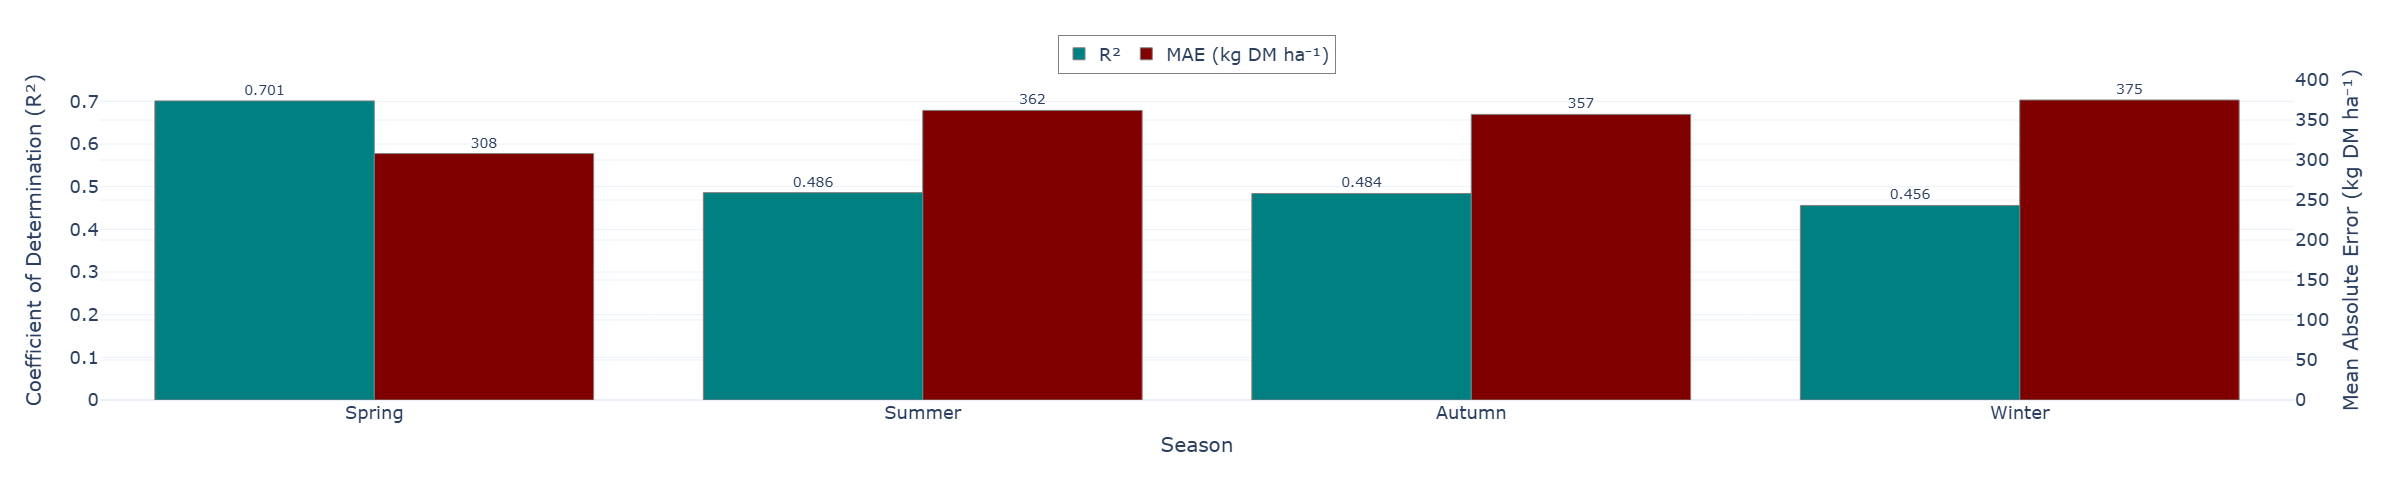

In [6]:
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

# REAL seasonal performance data for Experiment 17 from actual results
seasonal_data = {
    'Season': ['Spring', 'Summer', 'Autumn', 'Winter'],
    'R²': [0.701, 0.486, 0.484, 0.456],
    'MAE': [308, 362, 357, 375],
    'RMSE': [387, 449, 448, 460],
    'n_samples': [172, 151, 148, 188]
}

df = pd.DataFrame(seasonal_data)

# Create figure with secondary y-axis
fig = go.Figure()

# Add R² bars (primary y-axis)
fig.add_trace(go.Bar(
    x=df['Season'],
    y=df['R²'],
    name='R²',
    marker=dict(color='teal', line=dict(color='gray', width=1)),
    text=df['R²'].round(3),
    textposition='outside',
    textfont=dict(size=14),
    yaxis='y',
    offsetgroup=0
))

# Add MAE bars (secondary y-axis)
fig.add_trace(go.Bar(
    x=df['Season'],
    y=df['MAE'],
    name='MAE (kg DM ha⁻¹)',
    marker=dict(color='maroon', line=dict(color='gray', width=1)),
    text=df['MAE'].astype(int),
    textposition='outside',
    textfont=dict(size=14),
    yaxis='y2',
    offsetgroup=1
))

# Update layout with dual y-axes
fig.update_layout(
    template='plotly_white',
    xaxis=dict(
        title=dict(text='Season', font=dict(size=20)),
        tickfont=dict(size=18),
        categoryorder='array',
        categoryarray=['Spring', 'Summer', 'Autumn', 'Winter']
    ),
    yaxis=dict(
        title=dict(text='Coefficient of Determination (R²)', font=dict(size=20)),
        tickfont=dict(size=18),
        range=[0, 0.75],
        side='left'
    ),
    yaxis2=dict(
        title=dict(text='Mean Absolute Error (kg DM ha⁻¹)', font=dict(size=20)),
        tickfont=dict(size=18),
        overlaying='y',
        side='right',
        range=[0, 400]
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5,
        font=dict(size=18),
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    ),
    height=500,
    width=650,
    margin=dict(l=100, r=100, t=80, b=100),
    barmode='group'
)

fig.show()

# Or specify full path:
output_path = r'data/'
pio.write_image(fig, output_path, format='svg', scale=20)

### Distribution of Biomass

In [6]:
"""
STANDALONE: Generate Table X - Biomass Distribution Comparison
Loads data directly from CSV files - NO need to run Part 1A
"""

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
import os
from datetime import datetime

print("="*90)
print("GENERATING TABLE X: BIOMASS DISTRIBUTION COMPARISON")
print("="*90)
print(f"Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# ============================================================================
# CONFIGURATION
# ============================================================================
MAIN_FOLDER = r"data/"

# Folder choice (1 = Segme-cropped, 2 = LLM-masked)
FOLDER_CHOICE = 1  # Change if needed

if FOLDER_CHOICE == 1:
    matched_photos_folder = os.path.join(MAIN_FOLDER, "matched_photos_cropped")
    image_suffix = ".jpg"
else:
    ALTERNATIVE_FOLDER = r"data/"
    matched_photos_folder = os.path.join(ALTERNATIVE_FOLDER, "Anna Chlingaryan's files - matched_photos_cropped_ACh")
    image_suffix = "_masked.jpg"

TEST_SIZE = 0.2
RANDOM_STATE = 42

print(f"Folder: {matched_photos_folder}")
print(f"Image suffix: {image_suffix}\n")

# ============================================================================
# LOAD AND PROCESS DATA (MINIMAL VERSION)
# ============================================================================
print("[1/4] Loading data...")

# Load ADM data
matched_rpm_data = pd.read_csv(os.path.join(MAIN_FOLDER, "matched_rpm_data.csv"))
matched_rpm_data['date'] = pd.to_datetime(matched_rpm_data['date']).dt.date
matched_rpm_data['pcode'] = matched_rpm_data['pcode'].astype(str)

# Average ADM by farm, paddock, date
adm_averaged = matched_rpm_data.groupby(['farm_code', 'pcode', 'date']).agg({'ADM': 'mean'}).reset_index()
adm_averaged.columns = ['farm_code', 'pcode', 'date', 'avg_ADM']

print(f"✓ Loaded {len(adm_averaged)} ADM records")

# Match images to ADM data (minimal - just need ADM values)
modeling_data = []

for idx, row in adm_averaged.iterrows():
    farm = row['farm_code']
    paddock = row['pcode']
    date_obj = row['date']
    adm = row['avg_ADM']
    
    if not isinstance(date_obj, pd.Timestamp):
        date_obj = pd.to_datetime(date_obj)
    
    date_folder = date_obj.strftime('%Y_%m_%d')
    image_folder = os.path.join(matched_photos_folder, farm, date_folder)
    
    if not os.path.exists(image_folder):
        continue
    
    # Get candidate images
    if FOLDER_CHOICE == 1:
        candidate_images = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]
    else:
        candidate_images = [f for f in os.listdir(image_folder) if f.lower().endswith('_masked.jpg')]
    
    if not candidate_images:
        continue
    
    # Match by paddock or take first
    selected_image = None
    for img in candidate_images:
        parts = img.lower().replace('_masked.jpg', '').replace('.jpg', '').split('_')
        if len(parts) >= 2 and parts[1] == paddock:
            selected_image = img
            break
    
    if selected_image is None:
        selected_image = candidate_images[0]
    
    image_path = os.path.join(image_folder, selected_image)
    
    if os.path.exists(image_path):
        # Add season for stratification
        month = date_obj.month
        if month in [12, 1, 2]:
            season = 'Summer'
        elif month in [3, 4, 5]:
            season = 'Autumn'
        elif month in [6, 7, 8]:
            season = 'Winter'
        else:
            season = 'Spring'
        
        modeling_data.append({
            'farm': farm,
            'season': season,
            'ADM': adm
        })

df = pd.DataFrame(modeling_data)
print(f"✓ Matched {len(df)} samples with images")

# ============================================================================
# RECREATE TRAIN-TEST SPLIT
# ============================================================================
print("\n[2/4] Creating train-test split...")

# Get target variable
y = df['ADM'].values

# Create stratification column (farm + season)
df['strat'] = df['farm'].astype(str) + '_' + df['season'].astype(str)

# Train-test split (stratified)
_, _, y_train, y_test, idx_train, idx_test = train_test_split(
    df.index, y, df.index, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=df['strat']
)

print(f"✓ Train set: {len(y_train)} samples")
print(f"✓ Test set: {len(y_test)} samples")

# ============================================================================
# CALCULATE STATISTICS
# ============================================================================
print("\n[3/4] Calculating statistics...")

def calculate_stats(data, name, n):
    """Calculate all distribution statistics"""
    stats_dict = {
        'Dataset': name,
        'n': n,
        'Mean': np.mean(data),
        'Std Dev': np.std(data, ddof=1),
        'Minimum': np.min(data),
        'Maximum': np.max(data),
        'Median': np.median(data),
        '25th': np.percentile(data, 25),
        '75th': np.percentile(data, 75)
    }
    return stats_dict

train_stats = calculate_stats(y_train, 'Training Set', len(y_train))
test_stats = calculate_stats(y_test, 'Test Set', len(y_test))

# Perform t-test
t_stat, p_value = stats.ttest_ind(y_train, y_test)

print(f"✓ Statistics calculated")
print(f"✓ Two-sample t-test: t={t_stat:.3f}, p={p_value:.3f}")

# ============================================================================
# CREATE AND DISPLAY TABLE
# ============================================================================
print("\n[4/4] Generating table...")

characteristics = [
    ('Mean (kg DM ha⁻¹)', 'Mean'),
    ('Standard Deviation (kg DM ha⁻¹)', 'Std Dev'),
    ('Minimum (kg DM ha⁻¹)', 'Minimum'),
    ('Maximum (kg DM ha⁻¹)', 'Maximum'),
    ('Median (kg DM ha⁻¹)', 'Median'),
    ('25th Percentile (kg DM ha⁻¹)', '25th'),
    ('75th Percentile (kg DM ha⁻¹)', '75th')
]

print("\n" + "="*90)
print("TABLE X. Comparison of pasture biomass distributions in training and test sets")
print("="*90)
print(f"{'Characteristic':<40} {'Training Set (n=' + str(len(y_train)) + ')':<25} {'Test Set (n=' + str(len(y_test)) + ')':<20}")
print("-"*90)

for display_name, key in characteristics:
    train_val = train_stats[key]
    test_val = test_stats[key]
    print(f"{display_name:<40} {train_val:>20,.0f} {test_val:>20,.0f}")

print("-"*90)
print(f"\nTwo-sample t-test: t = {t_stat:.3f}, p = {p_value:.3f}")
if p_value > 0.05:
    print("✓ No significant difference between distributions (p > 0.05)")
else:
    print("⚠ Significant difference detected (p < 0.05)")
print("="*90)

# ============================================================================
# SAVE OUTPUTS (FIXED UTF-8 ENCODING)
# ============================================================================
print("\nSaving outputs...")

# 1. CSV
csv_output = os.path.join(MAIN_FOLDER, "TableX_Biomass_Distribution.csv")
csv_data = {
    'Characteristic': [x[0] for x in characteristics],
    f'Training Set (n={len(y_train)})': [f"{train_stats[x[1]]:.0f}" for x in characteristics],
    f'Test Set (n={len(y_test)})': [f"{test_stats[x[1]]:.0f}" for x in characteristics]
}
pd.DataFrame(csv_data).to_csv(csv_output, index=False, encoding='utf-8-sig')
print(f"✓ CSV saved: {csv_output}")

# 2. TXT (with UTF-8 encoding)
txt_output = os.path.join(MAIN_FOLDER, "TableX_Biomass_Distribution.txt")
with open(txt_output, 'w', encoding='utf-8') as f:  # <-- ADDED encoding='utf-8'
    f.write("TABLE X. Comparison of pasture biomass distributions in training and test sets\n")
    f.write("="*90 + "\n\n")
    f.write(f"{'Characteristic':<40} {'Training Set (n=' + str(len(y_train)) + ')':<25} {'Test Set (n=' + str(len(y_test)) + ')':<20}\n")
    f.write("-"*90 + "\n")
    for display_name, key in characteristics:
        f.write(f"{display_name:<40} {train_stats[key]:>20,.0f} {test_stats[key]:>20,.0f}\n")
    f.write("\n" + "-"*90 + "\n")
    f.write(f"Two-sample t-test: t = {t_stat:.3f}, p = {p_value:.3f}\n")
    if p_value > 0.05:
        f.write("No significant difference between distributions (p > 0.05)\n")
    f.write("="*90 + "\n")
print(f"✓ TXT saved: {txt_output}")

# 3. LaTeX (with UTF-8 encoding)
latex_output = os.path.join(MAIN_FOLDER, "TableX_Biomass_Distribution_LaTeX.txt")
with open(latex_output, 'w', encoding='utf-8') as f:  # <-- ADDED encoding='utf-8'
    f.write("\\begin{table}[h]\n")
    f.write("\\centering\n")
    f.write("\\caption{Comparison of pasture biomass distributions in training and test sets}\n")
    f.write("\\label{tab:biomass_distribution}\n")
    f.write("\\begin{tabular}{lcc}\n")
    f.write("\\hline\n")
    f.write(f"\\textbf{{Characteristic}} & \\textbf{{Training Set (n={len(y_train)})}} & \\textbf{{Test Set (n={len(y_test)})}} \\\\\n")
    f.write("\\hline\n")
    
    for display_name, key in characteristics:
        train_formatted = f"{train_stats[key]:,.0f}"
        test_formatted = f"{test_stats[key]:,.0f}"
        # For LaTeX, use proper notation
        display_latex = display_name.replace('ha⁻¹', 'ha$^{-1}$')
        f.write(f"{display_latex} & {train_formatted} & {test_formatted} \\\\\n")
    
    f.write("\\hline\n")
    f.write("\\end{tabular}\n")
    f.write(f"\\\\[0.5em]\n")
    f.write(f"\\footnotesize{{Two-sample $t$-test: $t = {t_stat:.3f}$, $p = {p_value:.3f}$ (no significant difference)}}\n")
    f.write("\\end{table}\n")
print(f"✓ LaTeX saved: {latex_output}")

print("\n" + "="*90)
print("✓ TABLE X COMPLETE!")
print("="*90)
print(f"\nActual split sizes:")
print(f"  Training: {len(y_train)} samples")
print(f"  Test: {len(y_test)} samples")
print(f"\nFiles saved:")
print(f"  1. CSV: {csv_output}")
print(f"  2. TXT: {txt_output}")
print(f"  3. LaTeX: {latex_output}")

GENERATING TABLE X: BIOMASS DISTRIBUTION COMPARISON
Time: 2025-12-11 21:38:42

Folder: C:\Users\bnnen\OneDrive - The University of Sydney (Staff)\PHD Journey, Files and Thesis\PHD Documents\Papers\Paper 5\matched_photos_cropped
Image suffix: .jpg

[1/4] Loading data...
✓ Loaded 3291 ADM records
✓ Matched 3291 samples with images

[2/4] Creating train-test split...
✓ Train set: 2632 samples
✓ Test set: 659 samples

[3/4] Calculating statistics...
✓ Statistics calculated
✓ Two-sample t-test: t=-1.468, p=0.142

[4/4] Generating table...

TABLE X. Comparison of pasture biomass distributions in training and test sets
Characteristic                           Training Set (n=2632)     Test Set (n=659)    
------------------------------------------------------------------------------------------
Mean (kg DM ha⁻¹)                                       2,732                2,772
Standard Deviation (kg DM ha⁻¹)                           640                  630
Minimum (kg DM ha⁻¹)               

### NEWEST VERSION

### Part1A: EDA and Data Loading

In [21]:
"""
COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 1A
Exploratory Data Analysis + Data Loading

RUN THIS ONCE to verify your data and load CSVs.
Then proceed to Part 1B for feature extraction.

This part prints comprehensive statistics but doesn't process images,
so it's fast and doesn't need to be rerun.
"""

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from datetime import datetime

print("="*80)
print("COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 1A")
print("Exploratory Data Analysis + Data Loading")
print("="*80)
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# ============================================================================
# CONFIGURATION
# ============================================================================
# FOLDER SELECTION: Change this to 1 or 2
FOLDER_CHOICE = 1  # 1 = Segme-cropped, 2 = LLM-masked

# Paths
MAIN_FOLDER = r"data/"
ALTERNATIVE_FOLDER = r"data/"

if FOLDER_CHOICE == 1:
    matched_photos_folder = os.path.join(MAIN_FOLDER, "matched_photos_cropped")
    image_suffix = ".jpg"
    folder_name = "Folder1_Segme"
    print(f">>> Processing: FOLDER 1 (Segme-cropped)")
else:
    matched_photos_folder = os.path.join(ALTERNATIVE_FOLDER, "Anna Chlingaryan's files - matched_photos_cropped_ACh")
    image_suffix = "_masked.jpg"
    folder_name = "Folder2_LLM"
    print(f">>> Processing: FOLDER 2 (LLM-masked)")

# Parameters
IMG_SIZE = 224
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

print(f"Image folder: {matched_photos_folder}")
print(f"Image suffix: {image_suffix}")
print(f"Random State: {RANDOM_STATE}")
print(f"Test Size: {TEST_SIZE} (80/20 split)")
print(f"CV Folds: {CV_FOLDS}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

# Load ADM data
matched_rpm_data = pd.read_csv(os.path.join(MAIN_FOLDER, "matched_rpm_data.csv"))
matched_rpm_data['date'] = pd.to_datetime(matched_rpm_data['date']).dt.date
matched_rpm_data['pcode'] = matched_rpm_data['pcode'].astype(str)

# Average ADM by farm, paddock, date
adm_averaged = matched_rpm_data.groupby(['farm_code', 'pcode', 'date']).agg({'ADM': 'mean'}).reset_index()
adm_averaged.columns = ['farm_code', 'pcode', 'date', 'avg_ADM']

print(f"✓ Total ADM records: {len(adm_averaged)}")

# Load weather data
# weather_data = pd.read_csv(os.path.join(MAIN_FOLDER, "weather_data.csv"))
weather_data = weather_data.copy()
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data['Farm Code'] = weather_data['Farm Code'].str.lower()

print(f"✓ Weather data loaded: {len(weather_data)} records")

# Match images to ADM data
modeling_data = []
missing_count = 0

for idx, row in adm_averaged.iterrows():
    farm = row['farm_code']
    paddock = row['pcode']
    date_obj = row['date']
    adm = row['avg_ADM']
    
    # Convert date to datetime for formatting
    if not isinstance(date_obj, pd.Timestamp):
        date_obj = pd.to_datetime(date_obj)
    
    date_folder = date_obj.strftime('%Y_%m_%d')
    image_folder = os.path.join(matched_photos_folder, farm, date_folder)
    
    if not os.path.exists(image_folder):
        missing_count += 1
        continue
    
    # Get candidate images based on folder choice
    if FOLDER_CHOICE == 1:
        candidate_images = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]
    else:
        candidate_images = [f for f in os.listdir(image_folder) if f.lower().endswith('_masked.jpg')]
    
    if not candidate_images:
        missing_count += 1
        continue
    
    # Try to match by paddock code
    selected_image = None
    for img in candidate_images:
        parts = img.lower().replace('_masked.jpg', '').replace('.jpg', '').split('_')
        if len(parts) >= 2 and parts[1] == paddock:
            selected_image = img
            break
    
    if selected_image is None:
        selected_image = candidate_images[0]
    
    image_path = os.path.join(image_folder, selected_image)
    
    if os.path.exists(image_path):
        # Match weather data
        weather_match = weather_data[
            (weather_data['Farm Code'] == farm.lower()) &
            (weather_data['Date'].dt.date == date_obj.date())
        ]
        
        if not weather_match.empty:
            weather_row = weather_match.iloc[0]
            modeling_data.append({
                'farm': farm,
                'paddock': paddock,
                'date': date_obj.date(),
                'ADM': adm,
                'image_path': image_path,
                'T.Max': weather_row.get('T.Max', np.nan),
                'T.Min': weather_row.get('T.Min', np.nan),
                'Rain': weather_row.get('Rain', np.nan),
                'Evap': weather_row.get('Evap', np.nan),
                'Radn': weather_row.get('Radn', np.nan),
                'VP': weather_row.get('VP', np.nan),
                'RHmaxT': weather_row.get('RHmaxT', np.nan),
                'RHminT': weather_row.get('RHminT', np.nan)
            })
        else:
            modeling_data.append({
                'farm': farm,
                'paddock': paddock,
                'date': date_obj.date(),
                'ADM': adm,
                'image_path': image_path,
                'T.Max': np.nan,
                'T.Min': np.nan,
                'Rain': np.nan,
                'Evap': np.nan,
                'Radn': np.nan,
                'VP': np.nan,
                'RHmaxT': np.nan,
                'RHminT': np.nan
            })
    else:
        missing_count += 1

df = pd.DataFrame(modeling_data)

print(f"✓ Successfully matched: {len(df)} samples")
print(f"✗ Missing images: {missing_count}")

# ============================================================================
# COMPREHENSIVE EXPLORATORY DATA ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# 1. FARM STATISTICS
print("\n1. FARM DISTRIBUTION")
print("-" * 80)
farm_counts = df['farm'].value_counts().sort_index()
n_farms = df['farm'].nunique()
print(f"Total unique farms: {n_farms}")
print(f"\nSample distribution across farms:")
for farm, count in farm_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {farm:15s}: {count:4d} samples ({percentage:5.1f}%)")

# 2. TEMPORAL DISTRIBUTION
print("\n2. TEMPORAL DISTRIBUTION")
print("-" * 80)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear

print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Duration: {(df['date'].max() - df['date'].min()).days} days")

print(f"\nYearly distribution:")
for year, count in df['year'].value_counts().sort_index().items():
    print(f"  {year}: {count} samples ({count/len(df)*100:.1f}%)")

# 3. GRASS TYPE DISTRIBUTION
print("\n3. GRASS TYPE DISTRIBUTION")
print("-" * 80)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

def get_grass_type(month):
    if month in [5, 6, 7, 8, 9, 10, 11]:
        return 'Ryegrass'
    else:
        return 'Kikuyu'

df['season'] = df['month'].apply(get_season)
df['grass_type'] = df['month'].apply(get_grass_type)

print(f"Grass type distribution:")
for grass, count in df['grass_type'].value_counts().items():
    months = "May-Nov" if grass == "Ryegrass" else "Dec-Apr"
    print(f"  {grass} ({months}): {count} samples ({count/len(df)*100:.1f}%)")

print(f"\nSeasonal distribution:")
for season in ['Summer', 'Autumn', 'Winter', 'Spring']:
    count = len(df[df['season'] == season])
    print(f"  {season}: {count} samples ({count/len(df)*100:.1f}%)")

# 4. PASTURE BIOMASS STATISTICS
print("\n4. PASTURE BIOMASS (ADM) STATISTICS")
print("-" * 80)
print(f"Mean:                {df['ADM'].mean():.1f} kg DM/ha")
print(f"Standard Deviation:  {df['ADM'].std():.1f} kg DM/ha")
print(f"Coefficient of Var:  {(df['ADM'].std()/df['ADM'].mean())*100:.1f}%")
print(f"Minimum:             {df['ADM'].min():.1f} kg DM/ha")
print(f"25th Percentile:     {df['ADM'].quantile(0.25):.1f} kg DM/ha")
print(f"Median:              {df['ADM'].median():.1f} kg DM/ha")
print(f"75th Percentile:     {df['ADM'].quantile(0.75):.1f} kg DM/ha")
print(f"Maximum:             {df['ADM'].max():.1f} kg DM/ha")

# Biomass ranges
def get_biomass_range(adm):
    if adm < 1800:
        return 'Low'
    elif adm < 3000:
        return 'Medium'
    else:
        return 'High'

df['biomass_range'] = df['ADM'].apply(get_biomass_range)

print(f"\nBiomass range distribution:")
print(f"  Low    (<1800 kg/ha):        {len(df[df['biomass_range']=='Low'])} samples ({len(df[df['biomass_range']=='Low'])/len(df)*100:.1f}%)")
print(f"  Medium (1800-3000 kg/ha):    {len(df[df['biomass_range']=='Medium'])} samples ({len(df[df['biomass_range']=='Medium'])/len(df)*100:.1f}%)")
print(f"  High   (>3000 kg/ha):        {len(df[df['biomass_range']=='High'])} samples ({len(df[df['biomass_range']=='High'])/len(df)*100:.1f}%)")

# 5. REGION DISTRIBUTION
print("\n5. REGIONAL DISTRIBUTION")
print("-" * 80)

# Region mapping
region_mapping = {
    'behrens': 'North Coast',
    'tonge': 'North Coast',
    'clarke': 'North Coast',
    'gould': 'North Coast',
    'neal': 'Mid Coast',
    'jneal': 'Mid Coast',
    'tocal': 'Mid Coast',
    'nicholson': 'Mid Coast',
    'bale': 'Mid Coast',
    'neilson': 'Mid Coast',
    'corstorphine': 'Mid Coast',
    'game': 'South Coast',
    'ryan': 'South Coast',
    'russell': 'South Coast',
    'apps': 'South Coast',
    'holmes': 'South Coast'
}

df['region'] = df['farm'].str.lower().map(region_mapping)

print(f"Regional distribution:")
for region in ['North Coast', 'Mid Coast', 'South Coast']:
    count = len(df[df['region'] == region])
    farms_in_region = df[df['region'] == region]['farm'].nunique()
    print(f"  {region:12s}: {count:4d} samples ({count/len(df)*100:5.1f}%) from {farms_in_region} farms")

# 6. WEATHER DATA COMPLETENESS
print("\n6. WEATHER DATA COMPLETENESS")
print("-" * 80)
weather_vars = ['T.Max', 'T.Min', 'Rain', 'Evap', 'Radn', 'VP', 'RHmaxT', 'RHminT']

total_missing = 0
for var in weather_vars:
    missing = df[var].isna().sum()
    total_missing += missing
    if missing > 0:
        print(f"  {var:8s}: {missing:3d} missing ({missing/len(df)*100:.2f}%)")

if total_missing == 0:
    print("  ✓ No missing weather data!")
else:
    print(f"\nTotal missing values: {total_missing} ({total_missing/(len(df)*len(weather_vars))*100:.2f}% of all weather data)")

# Impute missing weather with mean
for var in weather_vars:
    if df[var].isna().sum() > 0:
        df[var].fillna(df[var].mean(), inplace=True)

print(f"✓ Missing weather data imputed with column means")

# 7. SUMMARY STATISTICS TABLE
print("\n7. DATASET SUMMARY")
print("=" * 80)
print(f"Total samples:           {len(df)}")
print(f"Number of farms:         {n_farms}")
print(f"Number of paddocks:      {df['paddock'].nunique()}")
print(f"Date range:              {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Ryegrass samples:        {len(df[df['grass_type']=='Ryegrass'])} ({len(df[df['grass_type']=='Ryegrass'])/len(df)*100:.1f}%)")
print(f"Kikuyu samples:          {len(df[df['grass_type']=='Kikuyu'])} ({len(df[df['grass_type']=='Kikuyu'])/len(df)*100:.1f}%)")
print(f"Mean biomass:            {df['ADM'].mean():.1f} ± {df['ADM'].std():.1f} kg DM/ha")
print(f"Biomass range:           {df['ADM'].min():.1f} to {df['ADM'].max():.1f} kg DM/ha")

print("\n" + "="*80)
print("✓ PART 1A COMPLETE - DATA LOADED AND VERIFIED")
print("="*80)
print(f"\nEnd Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nNext Step: Run Part 1B for feature extraction and experiments 1-7")
print("="*80)

# Save processed dataframe for Part 1B
# (Part 1B will access df from this namespace if run in same session,
#  or you can pickle it if running in separate sessions)

COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 1A
Exploratory Data Analysis + Data Loading
Start Time: 2025-12-03 12:51:45

>>> Processing: FOLDER 1 (Segme-cropped)
Image folder: C:\Users\bnnen\OneDrive - The University of Sydney (Staff)\PHD Journey, Files and Thesis\PHD Documents\Papers\Paper 5\matched_photos_cropped
Image suffix: .jpg
Random State: 42
Test Size: 0.2 (80/20 split)
CV Folds: 5
Image Size: 224x224

LOADING DATA
✓ Total ADM records: 3291
✓ Weather data loaded: 87824 records
✓ Successfully matched: 3291 samples
✗ Missing images: 0

EXPLORATORY DATA ANALYSIS

1. FARM DISTRIBUTION
--------------------------------------------------------------------------------
Total unique farms: 15

Sample distribution across farms:
  apps           :  448 samples ( 13.6%)
  bale           :   10 samples (  0.3%)
  behrens        :  147 samples (  4.5%)
  clarke         :  141 samples (  4.3%)
  corstorphine   :  211 samples (  6.4%)
  game           :  444 samples ( 13.5%)
  gould       

### Part 1B: Feature extraction and Baseline Experiments (Experiments 1-7)

In [22]:
"""
COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 1B
Feature Extraction and Experiments 1-7 (Baseline + Deep Learning Failures)

PREREQUISITE: Must run Part 1A first!
This part assumes 'df' dataframe exists from Part 1A with columns:
- image_path, ADM, farm, paddock, date, weather variables

Author: PhD Research - Precision Agriculture
After Part 1B, run Part 2 and Part 3
"""

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import cv2
import time
from datetime import datetime

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from xgboost import XGBRegressor
from scipy.stats import skew, kurtosis

from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, DenseNet121
from tensorflow.keras import layers, Model
import tensorflow as tf

# ============================================================================
# CONFIGURATION
# ============================================================================
print("="*80)
print("COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 1B")
print("Feature Extraction and Experiments 1-7")
print("="*80)
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Check that Part 1A has been run
try:
    test_df = df.head()
    print(f"\n✓ Part 1A completed - df loaded with {len(df)} samples")
    print(f"✓ Folder: {folder_name}")
except NameError:
    print("\n✗ ERROR: 'df' not found! Please run Part 1A first.")
    raise RuntimeError("Part 1A must be run before Part 1B")

# Extract configuration from Part 1A
IMG_SIZE = 224
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

print(f"Random State: {RANDOM_STATE}")
print(f"Test Size: {TEST_SIZE}")
print(f"CV Folds: {CV_FOLDS}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")

# ============================================================================
# PREPARE DATA FROM PART 1A
# ============================================================================
print("\n" + "="*80)
print("[1/10] PREPARING DATA FROM PART 1A")
print("="*80)

# df already exists from Part 1A with columns:
# 'farm', 'paddock', 'date', 'ADM', 'image_path', weather variables, etc.

# Prepare targets and metadata lists
y_targets = df['ADM'].values
dates_list = df['date'].tolist()
farms_list = df['farm'].tolist()

# Helper function (already defined in Part 1A but repeated here for standalone use)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

print(f"✓ Prepared {len(df)} samples for feature extraction")
print(f"ADM range: [{y_targets.min():.0f}, {y_targets.max():.0f}] kg/ha")

# ============================================================================
# LOAD IMAGES
# ============================================================================
print("\n" + "="*80)
print("[2/10] LOADING IMAGES")
print("="*80)

def load_image(path):
    """Load and preprocess image"""
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Failed to load: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

X_images = []
failed_count = 0

for idx, row in df.iterrows():
    try:
        img = load_image(row['image_path'])
        X_images.append(img)
    except Exception as e:
        print(f"Failed to load {row['image_path']}: {e}")
        failed_count += 1

X = np.array(X_images)
y = y_targets

print(f"✓ Loaded images: {X.shape}")
print(f"✗ Failed to load: {failed_count}")
print(f"\nADM Statistics:")
print(f"  Mean: {y.mean():.0f} kg/ha")
print(f"  Std: {y.std():.0f} kg/ha")
print(f"  Range: [{y.min():.0f}, {y.max():.0f}] kg/ha")

# ============================================================================
# EXTRACT FEATURES - PART 1: HAND-CRAFTED
# ============================================================================
print("\n" + "="*80)
print("[3/10] EXTRACTING HAND-CRAFTED FEATURES")
print("="*80)

def extract_handcrafted_features(img):
    """
    Extract comprehensive hand-crafted features including:
    - RGB/HSV color statistics
    - Vegetation indices (VARI, GLI, NGRDI, ExG)
    - Texture features (GLCM, LBP)
    - Edge features
    - Spatial features
    """
    features = []
    feature_names = []
    
    # Convert for processing
    img_uint8 = (img * 255).astype(np.uint8)
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    
    # 1. RGB COLOR STATISTICS
    rgb_channels = ['R', 'G', 'B']
    for i, channel in enumerate(rgb_channels):
        channel_data = img[:,:,i]
        features.extend([
            np.mean(channel_data),
            np.std(channel_data),
            np.median(channel_data),
            np.percentile(channel_data, 25),
            np.percentile(channel_data, 75),
            skew(channel_data.flatten()),
            kurtosis(channel_data.flatten())
        ])
        feature_names.extend([
            f'{channel}_mean', f'{channel}_std', f'{channel}_median',
            f'{channel}_q25', f'{channel}_q75', f'{channel}_skew', f'{channel}_kurtosis'
        ])
    
    # 2. HSV COLOR STATISTICS
    hsv_channels = ['H', 'S', 'V']
    for i, channel in enumerate(hsv_channels):
        channel_data = hsv[:,:,i]
        features.extend([
            np.mean(channel_data),
            np.std(channel_data),
            np.median(channel_data)
        ])
        feature_names.extend([
            f'{channel}_mean', f'{channel}_std', f'{channel}_median'
        ])
    
    # 3. VEGETATION INDICES (standard in precision agriculture)
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    # Green ratio
    green_ratio = np.mean(G) / (np.mean(R) + np.mean(B) + 1e-6)
    features.append(green_ratio)
    feature_names.append('green_ratio')
    
    # Excess Green (ExG)
    excess_green = 2 * G - R - B
    features.extend([
        np.mean(excess_green),
        np.std(excess_green),
        np.percentile(excess_green, 75),
        np.percentile(excess_green, 25)
    ])
    feature_names.extend([
        'excess_green_mean', 'excess_green_std', 'excess_green_q75', 'excess_green_q25'
    ])
    
    # VARI (Visible Atmospherically Resistant Index)
    vari = (G - R) / (G + R - B + 1e-6)
    features.extend([
        np.mean(vari),
        np.std(vari)
    ])
    feature_names.extend(['vari_mean', 'vari_std'])
    
    # GLI (Green Leaf Index)
    gli = (2 * G - R - B) / (2 * G + R + B + 1e-6)
    features.extend([
        np.mean(gli),
        np.std(gli)
    ])
    feature_names.extend(['gli_mean', 'gli_std'])
    
    # NGRDI (Normalized Green-Red Difference Index)
    ngrdi = (G - R) / (G + R + 1e-6)
    features.extend([
        np.mean(ngrdi),
        np.std(ngrdi)
    ])
    feature_names.extend(['ngrdi_mean', 'ngrdi_std'])
    
    # 4. TEXTURE FEATURES (GLCM)
    glcm = graycomatrix(gray, [1, 3, 5], [0, np.pi/4, np.pi/2, 3*np.pi/4], 
                        256, symmetric=True, normed=True)
    
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
        values = graycoprops(glcm, prop).flatten()
        features.extend([np.mean(values), np.std(values)])
        feature_names.extend([f'glcm_{prop}_mean', f'glcm_{prop}_std'])
    
    # 5. TEXTURE FEATURES (LBP)
    lbp = local_binary_pattern(gray, 24, 3, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=26, range=(0, 26))
    hist = hist.astype(float) / (hist.sum() + 1e-6)
    features.extend([
        np.mean(hist),
        np.std(hist),
        np.max(hist),
        np.sum(hist[:5])
    ])
    feature_names.extend([
        'lbp_mean', 'lbp_std', 'lbp_max', 'lbp_low_freq'
    ])
    
    # 6. EDGE FEATURES
    edges = cv2.Canny(gray, 50, 150)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    
    features.extend([
        np.mean(edges),
        np.std(edges),
        np.mean(np.abs(sobel_x)),
        np.mean(np.abs(sobel_y)),
        np.mean(grad_mag),
        np.std(grad_mag),
        np.percentile(grad_mag, 90)
    ])
    feature_names.extend([
        'edge_mean', 'edge_std', 'sobel_x_mean', 'sobel_y_mean',
        'grad_mag_mean', 'grad_mag_std', 'grad_mag_p90'
    ])
    
    # 7. SPATIAL FEATURES (quadrants)
    h, w = img.shape[:2]
    quads = [
        img[0:h//2, 0:w//2],
        img[0:h//2, w//2:w],
        img[h//2:h, 0:w//2],
        img[h//2:h, w//2:w]
    ]
    quad_means = [np.mean(q[:,:,1]) for q in quads]  # Green channel
    features.extend(quad_means)
    features.append(np.std(quad_means))
    feature_names.extend([
        'quad_tl_green', 'quad_tr_green', 'quad_bl_green', 'quad_br_green',
        'quad_green_std'
    ])
    
    return np.array(features), feature_names

# Extract features
print("Extracting hand-crafted features from all images...")
start_time = time.time()

X_handcrafted = []
for i, img in enumerate(X):
    features, feature_names_list = extract_handcrafted_features(img)
    X_handcrafted.append(features)
    if i == 0:
        handcrafted_feature_names = feature_names_list

X_handcrafted = np.array(X_handcrafted)
scaler_hand = StandardScaler()
X_handcrafted_scaled = scaler_hand.fit_transform(X_handcrafted)

print(f"✓ Hand-crafted features: {X_handcrafted_scaled.shape}")
print(f"  Total features: {len(handcrafted_feature_names)}")
print(f"  Time: {time.time() - start_time:.1f}s")

# ============================================================================
# EXTRACT FEATURES - PART 2: CNN FEATURES
# ============================================================================
print("\n" + "="*80)
print("[4/10] EXTRACTING CNN FEATURES (4 ARCHITECTURES)")
print("="*80)

# ResNet50
print("Extracting ResNet50 features...")
start_time = time.time()
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg', 
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet_features = resnet.predict(X, batch_size=32, verbose=0)
scaler_resnet = StandardScaler()
resnet_scaled = scaler_resnet.fit_transform(resnet_features)
print(f"✓ ResNet50: {resnet_scaled.shape} | Time: {time.time() - start_time:.1f}s")

# VGG16
print("Extracting VGG16 features...")
start_time = time.time()
vgg = VGG16(weights='imagenet', include_top=False, pooling='avg', 
            input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg_features = vgg.predict(X, batch_size=32, verbose=0)
scaler_vgg = StandardScaler()
vgg_scaled = scaler_vgg.fit_transform(vgg_features)
print(f"✓ VGG16: {vgg_scaled.shape} | Time: {time.time() - start_time:.1f}s")

# MobileNetV2
print("Extracting MobileNetV2 features...")
start_time = time.time()
mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))
mobilenet_features = mobilenet.predict(X, batch_size=32, verbose=0)
scaler_mobilenet = StandardScaler()
mobilenet_scaled = scaler_mobilenet.fit_transform(mobilenet_features)
print(f"✓ MobileNetV2: {mobilenet_scaled.shape} | Time: {time.time() - start_time:.1f}s")

# DenseNet121
print("Extracting DenseNet121 features...")
start_time = time.time()
densenet = DenseNet121(weights='imagenet', include_top=False, pooling='avg',
                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
densenet_features = densenet.predict(X, batch_size=32, verbose=0)
scaler_densenet = StandardScaler()
densenet_scaled = scaler_densenet.fit_transform(densenet_features)
print(f"✓ DenseNet121: {densenet_scaled.shape} | Time: {time.time() - start_time:.1f}s")

# ============================================================================
# EXTRACT FEATURES - PART 3: METADATA & WEATHER
# ============================================================================
print("\n" + "="*80)
print("[5/10] EXTRACTING METADATA & WEATHER FEATURES")
print("="*80)

# Metadata
dates_dt = pd.to_datetime(dates_list)
months = dates_dt.month

# Seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

seasons = [get_season(m) for m in months]
season_dummies = pd.get_dummies(pd.Series(seasons), prefix='season')
farm_dummies = pd.get_dummies(pd.Series(farms_list), prefix='farm')
day_norm = pd.Series(dates_dt.dayofyear) / 365.0

metadata = pd.concat([season_dummies, farm_dummies, day_norm.rename('day_norm')], axis=1).values
print(f"✓ Metadata: {metadata.shape}")

# Weather (already in df from Part 1A)
weather_cols = ['T.Max', 'T.Min', 'Rain', 'Evap', 'Radn', 'VP', 'RHmaxT', 'RHminT']
weather_features = df[weather_cols].values
scaler_weather = StandardScaler()
weather_scaled = scaler_weather.fit_transform(weather_features)
print(f"✓ Weather: {weather_scaled.shape}")

# ============================================================================
# COMBINE FEATURES
# ============================================================================
print("\n" + "="*80)
print("[6/10] COMBINING FEATURE SETS")
print("="*80)

# Multi-CNN (all 4 CNNs + hand-crafted + metadata)
X_multi_cnn = np.hstack([
    X_handcrafted_scaled,
    resnet_scaled,
    vgg_scaled,
    mobilenet_scaled,
    densenet_scaled,
    metadata
])

# Multi-CNN + Weather
X_with_weather = np.hstack([X_multi_cnn, weather_scaled])

print(f"✓ Hand-crafted only: {X_handcrafted_scaled.shape[1]} features")
print(f"✓ Multi-CNN (no weather): {X_multi_cnn.shape[1]} features")
print(f"✓ Multi-CNN + Weather: {X_with_weather.shape[1]} features")

# ============================================================================
# TRAIN-TEST SPLIT
# ============================================================================
print("\n" + "="*80)
print("[7/10] CREATING TRAIN-TEST SPLIT")
print("="*80)

indices = np.arange(len(X_with_weather))

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_with_weather, y, indices,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print(f"✓ Train samples: {len(X_train)}")
print(f"✓ Test samples: {len(X_test)}")
print(f"  Train ADM: {y_train.mean():.0f} ± {y_train.std():.0f} kg/ha")
print(f"  Test ADM: {y_test.mean():.0f} ± {y_test.std():.0f} kg/ha")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def evaluate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    return r2, mae, rmse

def cross_validate_model(model, X, y, cv_folds=5):
    """Perform k-fold cross-validation and return detailed results"""
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    cv_results = {
        'fold': [],
        'r2': [],
        'mae': [],
        'rmse': []
    }
    
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        # Clone model and fit
        from sklearn.base import clone
        model_fold = clone(model)
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Predict and evaluate
        y_pred = model_fold.predict(X_fold_val)
        r2, mae, rmse = evaluate_metrics(y_fold_val, y_pred)
        
        cv_results['fold'].append(fold_num)
        cv_results['r2'].append(r2)
        cv_results['mae'].append(mae)
        cv_results['rmse'].append(rmse)
    
    return cv_results

def print_experiment_header(exp_num, exp_name):
    """Print formatted experiment header"""
    print("\n" + "="*80)
    print(f"EXPERIMENT {exp_num}: {exp_name}")
    print("="*80)

def print_cv_results(cv_results):
    """Print cross-validation results"""
    print("\nCross-Validation Results (5-fold):")
    for i in range(len(cv_results['fold'])):
        print(f"  Fold {cv_results['fold'][i]}: "
              f"R²={cv_results['r2'][i]:.3f}, "
              f"MAE={cv_results['mae'][i]:.0f}, "
              f"RMSE={cv_results['rmse'][i]:.0f}")
    
    print(f"  Mean: "
          f"R²={np.mean(cv_results['r2']):.3f}±{np.std(cv_results['r2']):.3f}, "
          f"MAE={np.mean(cv_results['mae']):.0f}±{np.std(cv_results['mae']):.0f}, "
          f"RMSE={np.mean(cv_results['rmse']):.0f}±{np.std(cv_results['rmse']):.0f}")

# Storage for all results
all_results = []
all_predictions = {}
all_cv_results = {}
all_feature_importance = {}
all_models = {}

# ============================================================================
# PHASE 1: BASELINE MODELS (Experiments 1-3)
# ============================================================================
print("\n" + "="*80)
print("[8/10] PHASE 1: BASELINE MODELS (Experiments 1-3)")
print("="*80)

X_train_hand = X_handcrafted_scaled[idx_train]
X_test_hand = X_handcrafted_scaled[idx_test]

# Experiment 1: Random Forest Baseline
print_experiment_header(1, "Random Forest (Hand-crafted features)")
start_time = time.time()

rf_base = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Cross-validation
cv_results_exp1 = cross_validate_model(rf_base, X_train_hand, y_train, CV_FOLDS)
print_cv_results(cv_results_exp1)

# Train and test
rf_base.fit(X_train_hand, y_train)
y_pred_exp1 = rf_base.predict(X_test_hand)
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp1)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

# Feature importance
feature_importance_exp1 = pd.DataFrame({
    'feature': handcrafted_feature_names,
    'importance': rf_base.feature_importances_
}).sort_values('importance', ascending=False).head(30)

print("\nTop 10 Features:")
for idx, row in feature_importance_exp1.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Store results
all_results.append({
    'exp_num': 1,
    'exp_name': 'RF_Baseline',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.mean(cv_results_exp1['r2']),
    'cv_r2_std': np.std(cv_results_exp1['r2']),
    'cv_mae_mean': np.mean(cv_results_exp1['mae']),
    'cv_mae_std': np.std(cv_results_exp1['mae'])
})
all_predictions['exp1_rf'] = y_pred_exp1
all_cv_results['exp1_rf'] = cv_results_exp1
all_feature_importance['exp1_rf'] = feature_importance_exp1
all_models['exp1_rf'] = rf_base

# Experiment 2: XGBoost Baseline
print_experiment_header(2, "XGBoost (Hand-crafted features)")
start_time = time.time()

xgb_base = XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

cv_results_exp2 = cross_validate_model(xgb_base, X_train_hand, y_train, CV_FOLDS)
print_cv_results(cv_results_exp2)

xgb_base.fit(X_train_hand, y_train)
y_pred_exp2 = xgb_base.predict(X_test_hand)
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp2)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

# Feature importance
feature_importance_exp2 = pd.DataFrame({
    'feature': handcrafted_feature_names,
    'importance': xgb_base.feature_importances_
}).sort_values('importance', ascending=False).head(30)

print("\nTop 10 Features:")
for idx, row in feature_importance_exp2.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

all_results.append({
    'exp_num': 2,
    'exp_name': 'XGB_Baseline',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.mean(cv_results_exp2['r2']),
    'cv_r2_std': np.std(cv_results_exp2['r2']),
    'cv_mae_mean': np.mean(cv_results_exp2['mae']),
    'cv_mae_std': np.std(cv_results_exp2['mae'])
})
all_predictions['exp2_xgb'] = y_pred_exp2
all_cv_results['exp2_xgb'] = cv_results_exp2
all_feature_importance['exp2_xgb'] = feature_importance_exp2
all_models['exp2_xgb'] = xgb_base

# Experiment 3: Gradient Boosting Baseline
print_experiment_header(3, "Gradient Boosting (Hand-crafted features)")
start_time = time.time()

gbm_base = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

cv_results_exp3 = cross_validate_model(gbm_base, X_train_hand, y_train, CV_FOLDS)
print_cv_results(cv_results_exp3)

gbm_base.fit(X_train_hand, y_train)
y_pred_exp3 = gbm_base.predict(X_test_hand)
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp3)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

feature_importance_exp3 = pd.DataFrame({
    'feature': handcrafted_feature_names,
    'importance': gbm_base.feature_importances_
}).sort_values('importance', ascending=False).head(30)

print("\nTop 10 Features:")
for idx, row in feature_importance_exp3.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

all_results.append({
    'exp_num': 3,
    'exp_name': 'GBM_Baseline',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.mean(cv_results_exp3['r2']),
    'cv_r2_std': np.std(cv_results_exp3['r2']),
    'cv_mae_mean': np.mean(cv_results_exp3['mae']),
    'cv_mae_std': np.std(cv_results_exp3['mae'])
})
all_predictions['exp3_gbm'] = y_pred_exp3
all_cv_results['exp3_gbm'] = cv_results_exp3
all_feature_importance['exp3_gbm'] = feature_importance_exp3
all_models['exp3_gbm'] = gbm_base

# ============================================================================
# PHASE 2: DEEP LEARNING FROM SCRATCH (Experiments 4-7)
# ============================================================================
print("\n" + "="*80)
print("[8/10] PHASE 2: DEEP LEARNING FROM SCRATCH (Experiments 4-7)")
print("="*80)

X_train_img = X[idx_train]
X_test_img = X[idx_test]

# Experiment 4: End-to-End ResNet50 Fine-tuning
print_experiment_header(4, "End-to-End ResNet50 Fine-tuning")
start_time = time.time()

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model_exp4 = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model_exp4.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_exp4 = model_exp4.fit(
    X_train_img, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=16,
    verbose=0
)

y_pred_exp4 = model_exp4.predict(X_test_img, verbose=0).flatten()
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp4)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")
print(f"  Note: Expected failure due to prediction collapse with small dataset")

all_results.append({
    'exp_num': 4,
    'exp_name': 'EndToEnd_ResNet50',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp4_e2e_resnet'] = y_pred_exp4
all_models['exp4_e2e_resnet'] = model_exp4

# Experiment 5: Custom Attention CNN
print_experiment_header(5, "Custom Attention CNN")
start_time = time.time()

# Build attention CNN
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Convolutional blocks
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)

# Attention mechanism
attention = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
x = layers.Multiply()([x, attention])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1)(x)

model_exp5 = Model(inputs=input_layer, outputs=output)
model_exp5.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_exp5 = model_exp5.fit(
    X_train_img, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=0
)

y_pred_exp5 = model_exp5.predict(X_test_img, verbose=0).flatten()
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp5)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")
print(f"  Note: Expected failure due to insufficient data for custom architecture")

all_results.append({
    'exp_num': 5,
    'exp_name': 'Attention_CNN',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp5_attention'] = y_pred_exp5
all_models['exp5_attention'] = model_exp5

# Experiment 6: Density Estimation Network
print_experiment_header(6, "Density Estimation Network")
start_time = time.time()

# Build density network (predicts density map then aggregates)
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Density map prediction
density_map = layers.Conv2D(1, (1, 1), activation='relu', padding='same')(x)

# Global aggregation
x = layers.GlobalAveragePooling2D()(density_map)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1)(x)

model_exp6 = Model(inputs=input_layer, outputs=output)
model_exp6.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_exp6 = model_exp6.fit(
    X_train_img, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=0
)

y_pred_exp6 = model_exp6.predict(X_test_img, verbose=0).flatten()
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp6)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")
print(f"  Note: Expected failure - no pixel-level spatial labels available")

all_results.append({
    'exp_num': 6,
    'exp_name': 'Density_Network',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp6_density'] = y_pred_exp6
all_models['exp6_density'] = model_exp6

# Experiment 7: Vision Transformer (ViT)
print_experiment_header(7, "Vision Transformer (ViT-small)")
start_time = time.time()

# Simple ViT-like architecture
num_patches = (IMG_SIZE // 16) ** 2
patch_size = 16
projection_dim = 64
num_heads = 4
transformer_layers = 4

# Patch embedding
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Extract patches
patches = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size)(input_layer)
patches = layers.Reshape((num_patches, projection_dim))(patches)

# Position embedding
positions = tf.range(start=0, limit=num_patches, delta=1)
position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
patches = patches + position_embedding

# Transformer blocks
for _ in range(transformer_layers):
    # Multi-head attention
    x1 = layers.LayerNormalization(epsilon=1e-6)(patches)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    x2 = layers.Add()([attention_output, patches])
    
    # MLP
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = layers.Dense(projection_dim * 2, activation='gelu')(x3)
    x3 = layers.Dropout(0.1)(x3)
    x3 = layers.Dense(projection_dim)(x3)
    x3 = layers.Dropout(0.1)(x3)
    patches = layers.Add()([x3, x2])

# Classification head
representation = layers.LayerNormalization(epsilon=1e-6)(patches)
representation = layers.GlobalAveragePooling1D()(representation)
representation = layers.Dropout(0.3)(representation)
features = layers.Dense(128, activation='gelu')(representation)
features = layers.Dropout(0.3)(features)
output = layers.Dense(1)(features)

model_exp7 = Model(inputs=input_layer, outputs=output)
model_exp7.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_exp7 = model_exp7.fit(
    X_train_img, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=0
)

y_pred_exp7 = model_exp7.predict(X_test_img, verbose=0).flatten()
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp7)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")
print(f"  Note: ViT requires very large datasets (10k+ images), expected below baseline")

all_results.append({
    'exp_num': 7,
    'exp_name': 'Vision_Transformer',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp7_vit'] = y_pred_exp7
all_models['exp7_vit'] = model_exp7

print("\n" + "="*80)
print("✓ PART 1 COMPLETE")
print("="*80)
print(f"Experiments 1-7 completed successfully")
print(f"Next: Run Part 2 for Experiments 8-14 (Transfer Learning)")
print("="*80)

COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 1B
Feature Extraction and Experiments 1-7
Start Time: 2025-12-03 12:56:21

✓ Part 1A completed - df loaded with 3291 samples
✓ Folder: Folder1_Segme
Random State: 42
Test Size: 0.2
CV Folds: 5
Image Size: 224x224

[1/10] PREPARING DATA FROM PART 1A
✓ Prepared 3291 samples for feature extraction
ADM range: [1066, 4622] kg/ha

[2/10] LOADING IMAGES
✓ Loaded images: (3291, 224, 224, 3)
✗ Failed to load: 0

ADM Statistics:
  Mean: 2740 kg/ha
  Std: 638 kg/ha
  Range: [1066, 4622] kg/ha

[3/10] EXTRACTING HAND-CRAFTED FEATURES
Extracting hand-crafted features from all images...
✓ Hand-crafted features: (3291, 67)
  Total features: 67
  Time: 406.1s

[4/10] EXTRACTING CNN FEATURES (4 ARCHITECTURES)
Extracting ResNet50 features...
✓ ResNet50: (3291, 2048) | Time: 206.1s
Extracting VGG16 features...
✓ VGG16: (3291, 512) | Time: 205.5s
Extracting MobileNetV2 features...
✓ MobileNetV2: (3291, 1280) | Time: 60.1s
Extracting DenseNet121 features...
✓

### Part 2: Transfer Learning Experiments (Experiments 8-14)

In [23]:
"""
COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 2
Experiments 8-14: Transfer Learning and Hyperparameter Optimization

PREREQUISITE: Must run Part 1 first
This script uses variables from Part 1:
- X_train, X_test, y_train, y_test
- idx_train, idx_test
- resnet_scaled, vgg_scaled, effnet_scaled, densenet_scaled
- X_multi_cnn, X_with_weather
- all_results, all_predictions, all_cv_results, all_models, all_feature_importance
"""

import time
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from scipy.optimize import minimize
import numpy as np

print("="*80)
print("COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 2")
print("Experiments 8-14: Transfer Learning and Hyperparameter Optimization")
print("="*80)

# ============================================================================
# PHASE 3: TRANSFER LEARNING (Experiments 8-13)
# ============================================================================
print("\n" + "="*80)
print("[9/10] PHASE 3: TRANSFER LEARNING (Experiments 8-13)")
print("="*80)

# Experiment 8: ResNet50 Features Only
print_experiment_header(8, "ResNet50 Transfer Learning")
start_time = time.time()

X_train_resnet = resnet_scaled[idx_train]
X_test_resnet = resnet_scaled[idx_test]

rf_resnet = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

cv_results_exp8 = cross_validate_model(rf_resnet, X_train_resnet, y_train, CV_FOLDS)
print_cv_results(cv_results_exp8)

rf_resnet.fit(X_train_resnet, y_train)
y_pred_exp8 = rf_resnet.predict(X_test_resnet)
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp8)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 8,
    'exp_name': 'ResNet50_TL',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.mean(cv_results_exp8['r2']),
    'cv_r2_std': np.std(cv_results_exp8['r2']),
    'cv_mae_mean': np.mean(cv_results_exp8['mae']),
    'cv_mae_std': np.std(cv_results_exp8['mae'])
})
all_predictions['exp8_resnet_tl'] = y_pred_exp8
all_cv_results['exp8_resnet_tl'] = cv_results_exp8
all_models['exp8_resnet_tl'] = rf_resnet

# Experiment 9: VGG16 Features Only
print_experiment_header(9, "VGG16 Transfer Learning")
start_time = time.time()

X_train_vgg = vgg_scaled[idx_train]
X_test_vgg = vgg_scaled[idx_test]

rf_vgg = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

cv_results_exp9 = cross_validate_model(rf_vgg, X_train_vgg, y_train, CV_FOLDS)
print_cv_results(cv_results_exp9)

rf_vgg.fit(X_train_vgg, y_train)
y_pred_exp9 = rf_vgg.predict(X_test_vgg)
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp9)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 9,
    'exp_name': 'VGG16_TL',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.mean(cv_results_exp9['r2']),
    'cv_r2_std': np.std(cv_results_exp9['r2']),
    'cv_mae_mean': np.mean(cv_results_exp9['mae']),
    'cv_mae_std': np.std(cv_results_exp9['mae'])
})
all_predictions['exp9_vgg_tl'] = y_pred_exp9
all_cv_results['exp9_vgg_tl'] = cv_results_exp9
all_models['exp9_vgg_tl'] = rf_vgg

# Experiment 10: MobileNetV2 Features Only
print_experiment_header(10, "MobileNetV2 Transfer Learning")
start_time = time.time()

X_train_mobilenet = mobilenet_scaled[idx_train]
X_test_mobilenet = mobilenet_scaled[idx_test]

rf_mobilenet = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

cv_results_exp10 = cross_validate_model(rf_mobilenet, X_train_mobilenet, y_train, CV_FOLDS)
print_cv_results(cv_results_exp10)

rf_mobilenet.fit(X_train_mobilenet, y_train)
y_pred_exp10 = rf_mobilenet.predict(X_test_mobilenet)
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp10)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 10,
    'exp_name': 'MobileNetV2_TL',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.mean(cv_results_exp10['r2']),
    'cv_r2_std': np.std(cv_results_exp10['r2']),
    'cv_mae_mean': np.mean(cv_results_exp10['mae']),
    'cv_mae_std': np.std(cv_results_exp10['mae'])
})
all_predictions['exp10_mobilenet_tl'] = y_pred_exp10
all_cv_results['exp10_mobilenet_tl'] = cv_results_exp10
all_models['exp10_mobilenet_tl'] = rf_mobilenet

# Experiment 11: DenseNet121 Features Only
print_experiment_header(11, "DenseNet121 Transfer Learning")
start_time = time.time()

X_train_densenet = densenet_scaled[idx_train]
X_test_densenet = densenet_scaled[idx_test]

rf_densenet = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

cv_results_exp11 = cross_validate_model(rf_densenet, X_train_densenet, y_train, CV_FOLDS)
print_cv_results(cv_results_exp11)

rf_densenet.fit(X_train_densenet, y_train)
y_pred_exp11 = rf_densenet.predict(X_test_densenet)
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp11)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 11,
    'exp_name': 'DenseNet_TL',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.mean(cv_results_exp11['r2']),
    'cv_r2_std': np.std(cv_results_exp11['r2']),
    'cv_mae_mean': np.mean(cv_results_exp11['mae']),
    'cv_mae_std': np.std(cv_results_exp11['mae'])
})
all_predictions['exp11_densenet_tl'] = y_pred_exp11
all_cv_results['exp11_densenet_tl'] = cv_results_exp11
all_models['exp11_densenet_tl'] = rf_densenet

# Experiment 12: Multi-CNN Ensemble (No Weather)
print_experiment_header(12, "Multi-CNN Ensemble (4 CNNs + Hand-crafted + Metadata, No Weather)")
start_time = time.time()

X_train_multi = X_multi_cnn[idx_train]
X_test_multi = X_multi_cnn[idx_test]

# Feature selection
print("Performing feature selection (top 120 features)...")
selector_multi = SelectKBest(mutual_info_regression, k=120)
X_train_multi_sel = selector_multi.fit_transform(X_train_multi, y_train)
X_test_multi_sel = selector_multi.transform(X_test_multi)

# Build ensemble of 3 models
rf_multi = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_multi = XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
gbm_multi = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

# Train all three
rf_multi.fit(X_train_multi_sel, y_train)
xgb_multi.fit(X_train_multi_sel, y_train)
gbm_multi.fit(X_train_multi_sel, y_train)

# Simple averaging
y_pred_exp12 = np.mean([
    rf_multi.predict(X_test_multi_sel),
    xgb_multi.predict(X_test_multi_sel),
    gbm_multi.predict(X_test_multi_sel)
], axis=0)

r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp12)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 12,
    'exp_name': 'MultiCNN_Ensemble_NoWeather',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp12_multicnn'] = y_pred_exp12
all_models['exp12_multicnn'] = {'rf': rf_multi, 'xgb': xgb_multi, 'gbm': gbm_multi, 'selector': selector_multi}

# Experiment 13: Multi-CNN with Weather (Simple Ensemble, No Stacking)
print_experiment_header(13, "Multi-CNN + Weather (Simple Ensemble)")
start_time = time.time()

X_train_w = X_with_weather[idx_train]
X_test_w = X_with_weather[idx_test]

# Feature selection
print("Performing feature selection (top 120 features)...")
selector_w = SelectKBest(mutual_info_regression, k=120)
X_train_w_sel = selector_w.fit_transform(X_train_w, y_train)
X_test_w_sel = selector_w.transform(X_test_w)

rf_w = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_w = XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
gbm_w = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

rf_w.fit(X_train_w_sel, y_train)
xgb_w.fit(X_train_w_sel, y_train)
gbm_w.fit(X_train_w_sel, y_train)

y_pred_exp13 = np.mean([
    rf_w.predict(X_test_w_sel),
    xgb_w.predict(X_test_w_sel),
    gbm_w.predict(X_test_w_sel)
], axis=0)

r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp13)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 13,
    'exp_name': 'MultiCNN_Weather_Simple',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp13_multicnn_weather'] = y_pred_exp13
all_models['exp13_multicnn_weather'] = {'rf': rf_w, 'xgb': xgb_w, 'gbm': gbm_w, 'selector': selector_w}

# ============================================================================
# HYPERPARAMETER OPTIMIZATION (Experiment 14)
# ============================================================================
print("\n" + "="*80)
print("[9/10] HYPERPARAMETER OPTIMIZATION (Experiment 14)")
print("="*80)

# Experiment 14: Hyperparameter Optimization via RandomizedSearchCV
print_experiment_header(14, "Hyperparameter Optimization (RandomizedSearchCV)")
start_time = time.time()

print("\nOptimizing hyperparameters for RF, XGB, and GBM on Multi-CNN + Weather features...")
print("Using 3-fold CV with 50 random parameter combinations per model")

# Define parameter distributions (discrete ranges for cleaner search)
rf_param_dist = {
    'n_estimators': [200, 250, 300, 350, 400, 450, 500],
    'max_depth': [20, 25, 30, 35, 40],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', None]
}

xgb_param_dist = {
    'n_estimators': [200, 250, 300, 350, 400, 450, 500],
    'max_depth': [5, 6, 7, 8, 9, 10, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

gbm_param_dist = {
    'n_estimators': [200, 250, 300, 350, 400, 450, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}

# Optimize Random Forest
print("\n1. Optimizing Random Forest...")
rf_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=3,
    scoring='r2',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
rf_random.fit(X_train_w_sel, y_train)
best_rf_params = rf_random.best_params_

print(f"  Best RF parameters:")
for param, value in best_rf_params.items():
    print(f"    {param}: {value}")
print(f"  Best CV R²: {rf_random.best_score_:.3f}")

# Optimize XGBoost
print("\n2. Optimizing XGBoost...")
xgb_base = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)
xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=3,
    scoring='r2',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
xgb_random.fit(X_train_w_sel, y_train)
best_xgb_params = xgb_random.best_params_

print(f"  Best XGB parameters:")
for param, value in best_xgb_params.items():
    print(f"    {param}: {value}")
print(f"  Best CV R²: {xgb_random.best_score_:.3f}")

# Optimize Gradient Boosting
print("\n3. Optimizing Gradient Boosting...")
gbm_base = GradientBoostingRegressor(random_state=RANDOM_STATE)
gbm_random = RandomizedSearchCV(
    estimator=gbm_base,
    param_distributions=gbm_param_dist,
    n_iter=50,
    cv=3,
    scoring='r2',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
gbm_random.fit(X_train_w_sel, y_train)
best_gbm_params = gbm_random.best_params_

print(f"  Best GBM parameters:")
for param, value in best_gbm_params.items():
    print(f"    {param}: {value}")
print(f"  Best CV R²: {gbm_random.best_score_:.3f}")

# Test ensemble with optimized parameters
print("\n4. Testing optimized ensemble...")
y_pred_exp14 = np.mean([
    rf_random.best_estimator_.predict(X_test_w_sel),
    xgb_random.best_estimator_.predict(X_test_w_sel),
    gbm_random.best_estimator_.predict(X_test_w_sel)
], axis=0)

r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp14)
train_time = time.time() - start_time

print(f"\nTest Performance (Optimized Ensemble):")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Total optimization time: {train_time:.1f}s")

all_results.append({
    'exp_num': 14,
    'exp_name': 'Hyperparameter_Optimization',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': (rf_random.best_score_ + xgb_random.best_score_ + gbm_random.best_score_) / 3,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp14_hyperparam_opt'] = y_pred_exp14
all_models['exp14_hyperparam_opt'] = {
    'rf': rf_random.best_estimator_,
    'xgb': xgb_random.best_estimator_,
    'gbm': gbm_random.best_estimator_,
    'best_params': {
        'rf': best_rf_params,
        'xgb': best_xgb_params,
        'gbm': best_gbm_params
    }
}

# Store best parameters for use in Part 3 (Stacking)
print("\n" + "="*80)
print("✓ HYPERPARAMETER OPTIMIZATION COMPLETE")
print("="*80)
print("Best parameters will be used in Part 3 for stacking ensemble")
print("="*80)


print("\n" + "="*80)
print("✓ PART 2 COMPLETE")
print("="*80)
print(f"Experiments 8-14 completed successfully")
print(f"  - Experiments 8-11: Individual CNN architectures")
print(f"  - Experiments 12-13: Multi-CNN ensembles")
print(f"  - Experiment 14: Hyperparameter optimization")
print(f"\nOptimized hyperparameters stored for Part 3")
print(f"Next: Run Part 3 for Experiments 15-21 (Stacking, Augmentation, Domain-Specific)")
print("="*80)

COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 2
Experiments 8-14: Transfer Learning and Hyperparameter Optimization

[9/10] PHASE 3: TRANSFER LEARNING (Experiments 8-13)

EXPERIMENT 8: ResNet50 Transfer Learning

Cross-Validation Results (5-fold):
  Fold 1: R²=0.091, MAE=462, RMSE=577
  Fold 2: R²=0.097, MAE=490, RMSE=613
  Fold 3: R²=0.107, MAE=460, RMSE=575
  Fold 4: R²=0.104, MAE=503, RMSE=618
  Fold 5: R²=0.095, MAE=504, RMSE=618
  Mean: R²=0.099±0.006, MAE=484±19, RMSE=600±20

Test Performance:
  R² = 0.152 | MAE = 495 kg/ha | RMSE = 606 kg/ha
  Training time: 126.9s

EXPERIMENT 9: VGG16 Transfer Learning

Cross-Validation Results (5-fold):
  Fold 1: R²=0.303, MAE=402, RMSE=506
  Fold 2: R²=0.368, MAE=412, RMSE=513
  Fold 3: R²=0.276, MAE=412, RMSE=518
  Fold 4: R²=0.309, MAE=434, RMSE=542
  Fold 5: R²=0.350, MAE=437, RMSE=524
  Mean: R²=0.321±0.033, MAE=419±14, RMSE=521±12

Test Performance:
  R² = 0.347 | MAE = 426 kg/ha | RMSE = 532 kg/ha
  Training time: 77.9s

EXPERIMENT 10

### Part 3: Stacking and Analysis updated (Experiments 15-21)

In [25]:
"""
COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 3
Experiments 15-21: Stacking, Augmentation, Domain-Specific Models
+ Leave-One-Farm-Out Cross-Validation
+ Comprehensive Performance Analysis

PREREQUISITE: Must run Part 1 and Part 2 first
This part uses optimized hyperparameters from Part 2 (Experiment 14)
"""

import time
import os
from sklearn.model_selection import KFold, LeaveOneGroupOut, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.optimize import minimize
import numpy as np
import pandas as pd

print("="*80)
print("COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 3")
print("Experiments 15-21: Stacking, Augmentation, Domain-Specific + LOFO CV")
print("="*80)

# ============================================================================
# PREPARE OPTIMIZED MODELS FROM PART 2
# ============================================================================
print("\n" + "="*80)
print("LOADING OPTIMIZED HYPERPARAMETERS FROM PART 2")
print("="*80)

# Get optimized parameters from Part 2 (Experiment 14)
if 'exp14_hyperparam_opt' in all_models:
    best_params = all_models['exp14_hyperparam_opt']['best_params']
    
    print("Optimized hyperparameters:")
    print(f"\nRandom Forest:")
    for param, value in best_params['rf'].items():
        print(f"  {param}: {value}")
    
    print(f"\nXGBoost:")
    for param, value in best_params['xgb'].items():
        print(f"  {param}: {value}")
    
    print(f"\nGradient Boosting:")
    for param, value in best_params['gbm'].items():
        print(f"  {param}: {value}")
    
    # Create tuned models with optimized hyperparameters
    rf_tuned = RandomForestRegressor(
        **best_params['rf'],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgb_tuned = XGBRegressor(
        **best_params['xgb'],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    gbm_tuned = GradientBoostingRegressor(
        **best_params['gbm'],
        random_state=RANDOM_STATE
    )
    
    print("\n✓ Optimized models loaded successfully")
else:
    print("\n⚠ WARNING: Optimized hyperparameters not found!")
    print("  Using default hyperparameters instead")
    
    # Fallback to reasonable defaults
    rf_tuned = RandomForestRegressor(
        n_estimators=400,
        max_depth=30,
        min_samples_split=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgb_tuned = XGBRegressor(
        n_estimators=400,
        max_depth=9,
        learning_rate=0.1,
        subsample=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    gbm_tuned = GradientBoostingRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        random_state=RANDOM_STATE
    )

kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# ============================================================================
# ADVANCED ENSEMBLE METHODS (Experiment 15)
# ============================================================================
print("\n" + "="*80)
print("[10/10] PHASE 4: ADVANCED ENSEMBLE METHODS (Experiment 15)")
print("="*80)

# Experiment 15: Weighted Ensemble (Optimized Weights)
print_experiment_header(15, "Weighted Ensemble (Optimized Weights)")
start_time = time.time()

# Use predictions from base models with optimized hyperparameters
rf_tuned.fit(X_train_w_sel, y_train)
xgb_tuned.fit(X_train_w_sel, y_train)
gbm_tuned.fit(X_train_w_sel, y_train)

base_preds_train = np.column_stack([
    rf_tuned.predict(X_train_w_sel),
    xgb_tuned.predict(X_train_w_sel),
    gbm_tuned.predict(X_train_w_sel)
])

base_preds_test = np.column_stack([
    rf_tuned.predict(X_test_w_sel),
    xgb_tuned.predict(X_test_w_sel),
    gbm_tuned.predict(X_test_w_sel)
])

# Optimize weights using scipy
def objective(weights):
    weights = weights / np.sum(weights)
    pred = np.dot(base_preds_train, weights)
    return np.mean((y_train - pred)**2)

initial_weights = np.array([0.33, 0.33, 0.34])
bounds = [(0, 1) for _ in range(3)]
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds)
optimal_weights = result.x / np.sum(result.x)

print(f"\nOptimal weights:")
print(f"  RF:  {optimal_weights[0]:.3f}")
print(f"  XGB: {optimal_weights[1]:.3f}")
print(f"  GBM: {optimal_weights[2]:.3f}")

y_pred_exp15 = np.dot(base_preds_test, optimal_weights)
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp15)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 15,
    'exp_name': 'Weighted_Ensemble',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp15_weighted'] = y_pred_exp15
all_models['exp15_weighted'] = {'weights': optimal_weights, 'base_models': [rf_tuned, xgb_tuned, gbm_tuned]}

# ============================================================================
# STACKING ENSEMBLE METHODS (Experiments 16-17)
# ============================================================================
print("\n" + "="*80)
print("[10/10] PHASE 5: STACKING ENSEMBLE METHODS (Experiments 16-17)")
print("="*80)

# Experiment 16: Stacking (No Weather)
print_experiment_header(16, "Stacking Ensemble (No Weather)")
start_time = time.time()

# Generate out-of-fold predictions
oof_train = np.zeros((len(X_train_multi_sel), 3))
oof_test = np.zeros((len(X_test_multi_sel), 3))

print("Generating out-of-fold predictions...")
for i, model in enumerate([rf_tuned, xgb_tuned, gbm_tuned]):
    model_name = ['RF', 'XGB', 'GBM'][i]
    print(f"  Processing {model_name}...")
    
    oof_train_model = np.zeros(len(X_train_multi_sel))
    oof_test_model = np.zeros(len(X_test_multi_sel))
    
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X_train_multi_sel), 1):
        from sklearn.base import clone
        model_fold = clone(model)
        model_fold.fit(X_train_multi_sel[train_idx], y_train[train_idx])
        oof_train_model[val_idx] = model_fold.predict(X_train_multi_sel[val_idx])
        oof_test_model += model_fold.predict(X_test_multi_sel) / CV_FOLDS
    
    oof_train[:, i] = oof_train_model
    oof_test[:, i] = oof_test_model

# Meta-learner
meta_model = Ridge(alpha=1.0)
meta_model.fit(oof_train, y_train)
y_pred_exp16 = meta_model.predict(oof_test)

r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp16)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 16,
    'exp_name': 'Stacking_NoWeather',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp16_stacking'] = y_pred_exp16
all_models['exp16_stacking'] = {'meta': meta_model, 'base': [rf_tuned, xgb_tuned, gbm_tuned]}

# Experiment 17: Stacking with Weather ⭐ BEST MODEL
print_experiment_header(17, "Stacking + Weather ⭐ BEST MODEL")
start_time = time.time()

# ============================================================================
# EXTRACT FEATURE IMPORTANCE FOR EXPERIMENT 17
# ============================================================================
print("\n" + "-"*80)
print("EXTRACTING FEATURE IMPORTANCE (Mutual Information Scores)")
print("-"*80)

# Create results directory (if not already exists)
if 'results_dir' not in dir():
    results_dir = os.path.join(MAIN_FOLDER, "Results", folder_name)
    os.makedirs(results_dir, exist_ok=True)

# Recreate feature selection to get MI scores
selector_exp17 = SelectKBest(mutual_info_regression, k=120)
selector_exp17.fit(X_train_w, y_train)
mi_scores = selector_exp17.scores_

# Create feature names (4,959 total)
# Hand-crafted (67)
handcrafted_names = (
    # RGB (21)
    [f'{c}_{s}' for c in ['R','G','B'] for s in ['mean','std','median','q25','q75','skew','kurtosis']] +
    # HSV (9)
    [f'{c}_{s}' for c in ['H','S','V'] for s in ['mean','std','median']] +
    # Vegetation indices (11)
    ['green_ratio','excess_green_mean','excess_green_std','excess_green_q75','excess_green_q25',
     'vari_mean','vari_std','gli_mean','gli_std','ngrdi_mean','ngrdi_std'] +
    # GLCM (10)
    [f'glcm_{p}_{s}' for p in ['contrast','dissimilarity','homogeneity','energy','correlation'] for s in ['mean','std']] +
    # LBP (4)
    ['lbp_mean','lbp_std','lbp_max','lbp_low_freq'] +
    # Edge (7)
    ['edge_mean','edge_std','sobel_x_mean','sobel_y_mean','grad_mag_mean','grad_mag_std','grad_mag_p90'] +
    # Spatial (5)
    ['quad_tl_green','quad_tr_green','quad_bl_green','quad_br_green','quad_green_std']
)

# CNN features (4,864)
cnn_names = (
    [f'ResNet50_feat_{i}' for i in range(2048)] +
    [f'VGG16_feat_{i}' for i in range(512)] +
    [f'MobileNetV2_feat_{i}' for i in range(1280)] +
    [f'DenseNet121_feat_{i}' for i in range(1024)]
)

# Metadata (20)
metadata_names = (
    ['season_Summer','season_Autumn','season_Winter','season_Spring'] +
    [f'farm_{i}' for i in range(15)] +
    ['day_of_year']
)

# Weather (8)
weather_names = ['T.Max','T.Min','Rain','Evap','Radn','VP','RHmaxT','RHminT']

# Combine all
all_feature_names = handcrafted_names + cnn_names + metadata_names + weather_names

assert len(all_feature_names) == 4959, f"Expected 4959, got {len(all_feature_names)}"
assert len(mi_scores) == 4959, f"MI scores mismatch: {len(mi_scores)}"

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'experiment': 'exp17',
    'feature_name': all_feature_names,
    'mi_score': mi_scores,
    'feature_type': (
        ['Hand-Crafted'] * 67 +
        ['Deep Learning'] * 4864 +
        ['Metadata'] * 20 +
        ['Weather'] * 8
    )
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('mi_score', ascending=False).reset_index(drop=True)
feature_importance_df['rank'] = range(1, len(feature_importance_df) + 1)

# Save full feature importance
output_path = os.path.join(results_dir, 'exp17_feature_importance_all.csv')
feature_importance_df.to_csv(output_path, index=False)
print(f"✓ Saved all features: {output_path}")

# Save top 120 (actually used in model)
top_120 = feature_importance_df.head(120).copy()
output_path_top = os.path.join(results_dir, 'exp17_feature_importance_top120.csv')
top_120.to_csv(output_path_top, index=False)
print(f"✓ Saved top 120: {output_path_top}")

# Print top 20
print("\nTop 20 features by mutual information:")
for idx, row in feature_importance_df.head(20).iterrows():
    print(f"  {row['rank']:2d}. {row['feature_name']:30s} ({row['feature_type']:15s}): {row['mi_score']:.6f}")

print("-"*80 + "\n")

# ============================================================================
# CONTINUE WITH STACKING ENSEMBLE TRAINING
# ============================================================================

# Generate out-of-fold predictions with weather
oof_train_w = np.zeros((len(X_train_w_sel), 3))
oof_test_w = np.zeros((len(X_test_w_sel), 3))

# Track CV metrics for each base model
cv_metrics_exp17 = {
    'RF': {'r2': [], 'mae': [], 'rmse': []},
    'XGB': {'r2': [], 'mae': [], 'rmse': []},
    'GBM': {'r2': [], 'mae': [], 'rmse': []}
}

print("Generating out-of-fold predictions with weather data...")
for i, model in enumerate([rf_tuned, xgb_tuned, gbm_tuned]):
    model_name = ['RF', 'XGB', 'GBM'][i]
    print(f"  Processing {model_name}...")
    
    oof_train_model = np.zeros(len(X_train_w_sel))
    oof_test_model = np.zeros(len(X_test_w_sel))
    
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X_train_w_sel), 1):
        from sklearn.base import clone
        model_fold = clone(model)
        model_fold.fit(X_train_w_sel[train_idx], y_train[train_idx])
        
        val_pred = model_fold.predict(X_train_w_sel[val_idx])
        oof_train_model[val_idx] = val_pred
        oof_test_model += model_fold.predict(X_test_w_sel) / CV_FOLDS
        
        # Calculate fold metrics
        r2_fold, mae_fold, rmse_fold = evaluate_metrics(y_train[val_idx], val_pred)
        cv_metrics_exp17[model_name]['r2'].append(r2_fold)
        cv_metrics_exp17[model_name]['mae'].append(mae_fold)
        cv_metrics_exp17[model_name]['rmse'].append(rmse_fold)
    
    oof_train_w[:, i] = oof_train_model
    oof_test_w[:, i] = oof_test_model

print("\nBase Model CV Performance:")
for model_name in ['RF', 'XGB', 'GBM']:
    print(f"  {model_name}: "
          f"R²={np.mean(cv_metrics_exp17[model_name]['r2']):.3f}±{np.std(cv_metrics_exp17[model_name]['r2']):.3f}, "
          f"MAE={np.mean(cv_metrics_exp17[model_name]['mae']):.0f}±{np.std(cv_metrics_exp17[model_name]['mae']):.0f}, "
          f"RMSE={np.mean(cv_metrics_exp17[model_name]['rmse']):.0f}±{np.std(cv_metrics_exp17[model_name]['rmse']):.0f}")

meta_model_w = Ridge(alpha=1.0)
meta_model_w.fit(oof_train_w, y_train)
y_pred_exp17 = meta_model_w.predict(oof_test_w)

r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp17)
train_time = time.time() - start_time

print(f"\n⭐ BEST MODEL Test Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 17,
    'exp_name': 'Stacking_Weather_BEST',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.mean(cv_metrics_exp17['RF']['r2']),
    'cv_r2_std': np.std(cv_metrics_exp17['RF']['r2']),
    'cv_mae_mean': np.mean(cv_metrics_exp17['RF']['mae']),
    'cv_mae_std': np.std(cv_metrics_exp17['RF']['mae'])
})
all_predictions['exp17_stacking_weather'] = y_pred_exp17
all_cv_results['exp17_stacking_weather'] = cv_metrics_exp17
all_models['exp17_stacking_weather'] = {'meta': meta_model_w, 'base': [rf_tuned, xgb_tuned, gbm_tuned]}

# Store best model for later analysis
best_model_predictions = y_pred_exp17
best_model_name = 'exp17_stacking_weather'

# ============================================================================
# DATA AUGMENTATION (Experiment 18)
# ============================================================================
print("\n" + "="*80)
print("[10/10] AUGMENTATION EXPERIMENT (Experiment 18)")
print("="*80)

# Experiment 18: Training with Data Augmentation
print_experiment_header(18, "Training with Data Augmentation")
start_time = time.time()

# Create augmented training data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Generate augmented images (2x augmentation per image)
aug_images = []
aug_targets = []

X_train_img_subset = X[idx_train]
print(f"Generating augmented training set (original: {len(X_train_img_subset)} samples)...")

for img, target in zip(X_train_img_subset, y_train):
    # Original image
    aug_images.append(img)
    aug_targets.append(target)
    
    # Generate 2 augmented versions
    img_expanded = img.reshape((1,) + img.shape)
    aug_iter = datagen.flow(img_expanded, batch_size=1)
    
    for _ in range(2):
        aug_img = next(aug_iter)[0]
        aug_images.append(aug_img)
        aug_targets.append(target)

X_train_aug = np.array(aug_images)
y_train_aug = np.array(aug_targets)

print(f"✓ Augmented training set: {len(X_train_aug)} samples (3x original)")

# Extract ResNet50 features from augmented data
print("Extracting ResNet50 features from augmented images...")
resnet_aug = resnet.predict(X_train_aug, batch_size=32, verbose=0)
resnet_aug_scaled = scaler_resnet.transform(resnet_aug)

# Train on augmented data with optimized hyperparameters
from sklearn.base import clone
rf_aug = clone(rf_tuned)
rf_aug.fit(resnet_aug_scaled, y_train_aug)

# Test on original test set
y_pred_exp18 = rf_aug.predict(X_test_resnet)
r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp18)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 18,
    'exp_name': 'Training_Augmentation',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp18_augmentation'] = y_pred_exp18
all_models['exp18_augmentation'] = rf_aug

# ============================================================================
# DOMAIN-SPECIFIC MODELS (Experiments 19-21)
# ============================================================================
print("\n" + "="*80)
print("[10/10] DOMAIN-SPECIFIC MODELS (Experiments 19-21)")
print("="*80)

# Grass-specific masks
months_array = np.array([pd.to_datetime(d).month for d in dates_list])
ryegrass_mask = np.isin(months_array, [5, 6, 7, 8, 9, 10, 11])
kikuyu_mask = np.isin(months_array, [12, 1, 2, 3, 4])

# Experiment 19: Ryegrass-Specific Model (May-Nov)
print_experiment_header(19, "Ryegrass-Specific Model (May-Nov)")
start_time = time.time()

X_rye = X_with_weather[ryegrass_mask]
y_rye = y[ryegrass_mask]

print(f"Ryegrass samples: {len(X_rye)} ({len(X_rye)/len(X)*100:.1f}% of total)")

X_train_rye, X_test_rye, y_train_rye, y_test_rye = train_test_split(
    X_rye, y_rye,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Feature selection
selector_rye = SelectKBest(mutual_info_regression, k=80)
X_train_rye_sel = selector_rye.fit_transform(X_train_rye, y_train_rye)
X_test_rye_sel = selector_rye.transform(X_test_rye)

# Stacking for ryegrass
oof_train_rye = np.zeros((len(X_train_rye_sel), 3))
oof_test_rye = np.zeros((len(X_test_rye_sel), 3))

for i, model in enumerate([rf_tuned, xgb_tuned, gbm_tuned]):
    oof_train_model = np.zeros(len(X_train_rye_sel))
    oof_test_model = np.zeros(len(X_test_rye_sel))
    
    for train_idx, val_idx in kfold.split(X_train_rye_sel):
        from sklearn.base import clone
        model_fold = clone(model)
        model_fold.fit(X_train_rye_sel[train_idx], y_train_rye[train_idx])
        oof_train_model[val_idx] = model_fold.predict(X_train_rye_sel[val_idx])
        oof_test_model += model_fold.predict(X_test_rye_sel) / CV_FOLDS
    
    oof_train_rye[:, i] = oof_train_model
    oof_test_rye[:, i] = oof_test_model

meta_rye = Ridge(alpha=1.0)
meta_rye.fit(oof_train_rye, y_train_rye)
y_pred_rye = meta_rye.predict(oof_test_rye)

r2, mae, rmse = evaluate_metrics(y_test_rye, y_pred_rye)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 19,
    'exp_name': 'Ryegrass_Specific',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp19_ryegrass'] = y_pred_rye
all_models['exp19_ryegrass'] = {'meta': meta_rye}

# Experiment 20: Kikuyu-Specific Model (Dec-Apr)
print_experiment_header(20, "Kikuyu-Specific Model (Dec-Apr)")
start_time = time.time()

X_kik = X_with_weather[kikuyu_mask]
y_kik = y[kikuyu_mask]

print(f"Kikuyu samples: {len(X_kik)} ({len(X_kik)/len(X)*100:.1f}% of total)")

X_train_kik, X_test_kik, y_train_kik, y_test_kik = train_test_split(
    X_kik, y_kik,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Feature selection
selector_kik = SelectKBest(mutual_info_regression, k=80)
X_train_kik_sel = selector_kik.fit_transform(X_train_kik, y_train_kik)
X_test_kik_sel = selector_kik.transform(X_test_kik)

# Stacking for kikuyu
oof_train_kik = np.zeros((len(X_train_kik_sel), 3))
oof_test_kik = np.zeros((len(X_test_kik_sel), 3))

for i, model in enumerate([rf_tuned, xgb_tuned, gbm_tuned]):
    oof_train_model = np.zeros(len(X_train_kik_sel))
    oof_test_model = np.zeros(len(X_test_kik_sel))
    
    for train_idx, val_idx in kfold.split(X_train_kik_sel):
        from sklearn.base import clone
        model_fold = clone(model)
        model_fold.fit(X_train_kik_sel[train_idx], y_train_kik[train_idx])
        oof_train_model[val_idx] = model_fold.predict(X_train_kik_sel[val_idx])
        oof_test_model += model_fold.predict(X_test_kik_sel) / CV_FOLDS
    
    oof_train_kik[:, i] = oof_train_model
    oof_test_kik[:, i] = oof_test_model

meta_kik = Ridge(alpha=1.0)
meta_kik.fit(oof_train_kik, y_train_kik)
y_pred_kik = meta_kik.predict(oof_test_kik)

r2, mae, rmse = evaluate_metrics(y_test_kik, y_pred_kik)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 20,
    'exp_name': 'Kikuyu_Specific',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp20_kikuyu'] = y_pred_kik
all_models['exp20_kikuyu'] = {'meta': meta_kik}

# Experiment 21: Combined Grass-Specific Ensemble
print_experiment_header(21, "Combined Grass-Specific Ensemble")
start_time = time.time()

# For each test sample, use appropriate grass-specific model
y_pred_exp21 = np.zeros(len(y_test))
test_months = np.array([pd.to_datetime(dates_list[i]).month for i in idx_test])

# Count how many samples go to each model
rye_count = 0
kik_count = 0

for i, month in enumerate(test_months):
    test_sample_idx = idx_test[i]
    
    if month in [5, 6, 7, 8, 9, 10, 11]:
        # Use ryegrass model - but need to transform this single sample
        sample = X_with_weather[test_sample_idx].reshape(1, -1)
        sample_sel = selector_rye.transform(sample)
        
        # Get predictions from all 3 base models
        base_preds = np.array([
            rf_tuned.fit(X_train_rye_sel, y_train_rye).predict(sample_sel)[0],
            xgb_tuned.fit(X_train_rye_sel, y_train_rye).predict(sample_sel)[0],
            gbm_tuned.fit(X_train_rye_sel, y_train_rye).predict(sample_sel)[0]
        ]).reshape(1, -1)
        
        y_pred_exp21[i] = meta_rye.predict(base_preds)[0]
        rye_count += 1
    else:
        # Use kikuyu model
        sample = X_with_weather[test_sample_idx].reshape(1, -1)
        sample_sel = selector_kik.transform(sample)
        
        base_preds = np.array([
            rf_tuned.fit(X_train_kik_sel, y_train_kik).predict(sample_sel)[0],
            xgb_tuned.fit(X_train_kik_sel, y_train_kik).predict(sample_sel)[0],
            gbm_tuned.fit(X_train_kik_sel, y_train_kik).predict(sample_sel)[0]
        ]).reshape(1, -1)
        
        y_pred_exp21[i] = meta_kik.predict(base_preds)[0]
        kik_count += 1

print(f"\nTest set composition:")
print(f"  Ryegrass model: {rye_count} samples ({rye_count/len(y_test)*100:.1f}%)")
print(f"  Kikuyu model: {kik_count} samples ({kik_count/len(y_test)*100:.1f}%)")

r2, mae, rmse = evaluate_metrics(y_test, y_pred_exp21)
train_time = time.time() - start_time

print(f"\nTest Performance:")
print(f"  R² = {r2:.3f} | MAE = {mae:.0f} kg/ha | RMSE = {rmse:.0f} kg/ha")
print(f"  Training time: {train_time:.1f}s")

all_results.append({
    'exp_num': 21,
    'exp_name': 'Combined_Grass_Ensemble',
    'r2': r2,
    'mae': mae,
    'rmse': rmse,
    'train_time': train_time,
    'cv_r2_mean': np.nan,
    'cv_r2_std': np.nan,
    'cv_mae_mean': np.nan,
    'cv_mae_std': np.nan
})
all_predictions['exp21_combined_grass'] = y_pred_exp21

# ============================================================================
# LEAVE-ONE-FARM-OUT CROSS-VALIDATION (BEST MODEL ONLY)
# ============================================================================
print("\n" + "="*80)
print("LEAVE-ONE-FARM-OUT CROSS-VALIDATION (BEST MODEL)")
print("="*80)

print(f"\nPerforming LOFO CV on Experiment 17 (Stacking + Weather)...")

# Get farm labels for all samples
farms_array = np.array(farms_list)
logo = LeaveOneGroupOut()

lofo_results = []

for train_idx_lofo, test_idx_lofo in logo.split(X_with_weather, y, groups=farms_array):
    test_farm = farms_array[test_idx_lofo[0]]
    
    X_train_lofo = X_with_weather[train_idx_lofo]
    X_test_lofo = X_with_weather[test_idx_lofo]
    y_train_lofo = y[train_idx_lofo]
    y_test_lofo = y[test_idx_lofo]
    
    # Feature selection
    selector_lofo = SelectKBest(mutual_info_regression, k=120)
    X_train_lofo_sel = selector_lofo.fit_transform(X_train_lofo, y_train_lofo)
    X_test_lofo_sel = selector_lofo.transform(X_test_lofo)
    
    # Train stacking ensemble
    oof_train_lofo = np.zeros((len(X_train_lofo_sel), 3))
    oof_test_lofo = np.zeros((len(X_test_lofo_sel), 3))
    
    for i, model in enumerate([rf_tuned, xgb_tuned, gbm_tuned]):
        oof_train_model = np.zeros(len(X_train_lofo_sel))
        oof_test_model = np.zeros(len(X_test_lofo_sel))
        
        kfold_lofo = KFold(n_splits=min(5, len(X_train_lofo_sel)), shuffle=True, random_state=RANDOM_STATE)
        
        for train_idx, val_idx in kfold_lofo.split(X_train_lofo_sel):
            from sklearn.base import clone
            model_fold = clone(model)
            model_fold.fit(X_train_lofo_sel[train_idx], y_train_lofo[train_idx])
            oof_train_model[val_idx] = model_fold.predict(X_train_lofo_sel[val_idx])
            oof_test_model += model_fold.predict(X_test_lofo_sel) / min(5, len(X_train_lofo_sel))
        
        oof_train_lofo[:, i] = oof_train_model
        oof_test_lofo[:, i] = oof_test_model
    
    meta_lofo = Ridge(alpha=1.0)
    meta_lofo.fit(oof_train_lofo, y_train_lofo)
    y_pred_lofo = meta_lofo.predict(oof_test_lofo)
    
    r2_lofo, mae_lofo, rmse_lofo = evaluate_metrics(y_test_lofo, y_pred_lofo)
    
    lofo_results.append({
        'farm': test_farm,
        'n_samples': len(y_test_lofo),
        'mean_adm': np.mean(y_test_lofo),
        'r2': r2_lofo,
        'mae': mae_lofo,
        'rmse': rmse_lofo
    })
    
    print(f"  {test_farm}: R²={r2_lofo:.3f}, MAE={mae_lofo:.0f}, n={len(y_test_lofo)}")

lofo_df = pd.DataFrame(lofo_results)

# Add anonymous farm IDs for reporting
lofo_df['farm_id'] = lofo_df['farm'].map(farm_anon_mapping)
# Reorder columns to put farm_id after farm
cols = list(lofo_df.columns)
cols.insert(1, cols.pop(cols.index('farm_id')))
lofo_df = lofo_df[cols]

print(f"\nLOFO CV Summary:")
print(f"  Mean R²: {lofo_df['r2'].mean():.3f} ± {lofo_df['r2'].std():.3f}")
print(f"  Mean MAE: {lofo_df['mae'].mean():.0f} ± {lofo_df['mae'].std():.0f}")
print(f"  Mean RMSE: {lofo_df['rmse'].mean():.0f} ± {lofo_df['rmse'].std():.0f}")

# ============================================================================
# PERFORMANCE BREAKDOWN BY GROUPS
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE ANALYSIS BY GROUPS (BEST MODEL)")
print("="*80)

def calculate_performance_by_group(y_true, y_pred, group_labels, group_name):
    """Calculate performance metrics by group"""
    results = []
    unique_groups = np.unique(group_labels)
    
    for group in unique_groups:
        mask = group_labels == group
        if np.sum(mask) >= 3:  # At least 3 samples
            r2, mae, rmse = evaluate_metrics(y_true[mask], y_pred[mask])
            results.append({
                group_name: group,
                'n': np.sum(mask),
                'mean_adm': np.mean(y_true[mask]),
                'sd_adm': np.std(y_true[mask]),
                'r2': r2,
                'mae': mae,
                'rmse': rmse
            })
    
    return pd.DataFrame(results)

# Get test set metadata
test_farms = np.array(farms_list)[idx_test]
test_dates = np.array(dates_list)[idx_test]
test_months = pd.to_datetime(test_dates).month
test_seasons = [get_season(m) for m in test_months]

# Region mapping
region_mapping = {
    'behrens': 'North Coast',
    'tonge': 'North Coast',
    'clarke': 'North Coast',
    'gould': 'North Coast',
    'neal': 'Mid Coast',
    'jneal': 'Mid Coast',
    'tocal': 'Mid Coast',
    'nicholson': 'Mid Coast',
    'bale': 'Mid Coast',
    'neilson': 'Mid Coast',
    'corstorphine': 'Mid Coast',
    'game': 'South Coast',
    'ryan': 'South Coast',
    'russell': 'South Coast',
    'apps': 'South Coast',
    'holmes': 'South Coast'
}
test_regions = np.array([region_mapping.get(f.lower(), 'Unknown') for f in test_farms])

# Farm anonymization mapping for reporting/visualization
# Maps actual farm names to anonymous IDs for publication
unique_test_farms = sorted(set(test_farms))
farm_anon_mapping = {farm: f'Farm_{i+1}' for i, farm in enumerate(sorted(set(farms_list)))}
print(f"\nFarm anonymization mapping (for reporting):")
for farm, farm_id in sorted(farm_anon_mapping.items()):
    print(f"  {farm:15s} → {farm_id}")

# Biomass ranges
biomass_ranges = []
for adm in y_test:
    if adm < 1800:
        biomass_ranges.append('Low')
    elif adm < 3000:
        biomass_ranges.append('Medium')
    else:
        biomass_ranges.append('High')
biomass_ranges = np.array(biomass_ranges)

# Calculate performance by different groups
print("\n1. Performance by Biomass Range:")
perf_by_range = calculate_performance_by_group(y_test, best_model_predictions, biomass_ranges, 'biomass_range')

# Add biomass range definitions for reporting
range_definitions = {
    'Low': 'Low (<1800 kg/ha)',
    'Medium': 'Medium (1800-3000 kg/ha)',
    'High': 'High (>3000 kg/ha)'
}
perf_by_range['range_definition'] = perf_by_range['biomass_range'].map(range_definitions)
# Reorder columns to put definition after range
cols = list(perf_by_range.columns)
cols.insert(1, cols.pop(cols.index('range_definition')))
perf_by_range = perf_by_range[cols]

print(perf_by_range.to_string(index=False))

print("\n2. Performance by Season:")
perf_by_season = calculate_performance_by_group(y_test, best_model_predictions, np.array(test_seasons), 'season')
print(perf_by_season.to_string(index=False))

print("\n3. Performance by Farm:")
perf_by_farm = calculate_performance_by_group(y_test, best_model_predictions, test_farms, 'farm')

# Add anonymous farm IDs for reporting
perf_by_farm['farm_id'] = perf_by_farm['farm'].map(farm_anon_mapping)
# Reorder columns to put farm_id after farm
cols = list(perf_by_farm.columns)
cols.insert(1, cols.pop(cols.index('farm_id')))
perf_by_farm = perf_by_farm[cols]

print(perf_by_farm.to_string(index=False))

print("\n4. Performance by Region:")
perf_by_region = calculate_performance_by_group(y_test, best_model_predictions, test_regions, 'region')
print(perf_by_region.to_string(index=False))

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("✓ ALL EXPERIMENTS COMPLETE")
print("="*80)
print(f"Total experiments: 21")
print(f"Best model: Experiment 17 (Stacking + Weather)")
print(f"  Test R² = {all_results[16]['r2']:.3f}")  # Index 16 because list is 0-indexed
print(f"  Test MAE = {all_results[16]['mae']:.0f} kg/ha")
print(f"  Test RMSE = {all_results[16]['rmse']:.0f} kg/ha")
print(f"\nLOFO CV (generalization):")
print(f"  Mean R² = {lofo_df['r2'].mean():.3f} ± {lofo_df['r2'].std():.3f}")
print(f"  Mean MAE = {lofo_df['mae'].mean():.0f} ± {lofo_df['mae'].std():.0f}")
print("="*80)
print("\nNext: Run Part 4 (Results Export) to save all CSVs")
print("="*80)

# Store all performance breakdowns for export
perf_by_range_all = perf_by_range
perf_by_season_all = perf_by_season
perf_by_farm_all = perf_by_farm
perf_by_region_all = perf_by_region
lofo_results_df = lofo_df

COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 3
Experiments 15-21: Stacking, Augmentation, Domain-Specific + LOFO CV

LOADING OPTIMIZED HYPERPARAMETERS FROM PART 2
Optimized hyperparameters:

Random Forest:
  n_estimators: 500
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: None
  max_depth: 25

XGBoost:
  subsample: 0.7
  n_estimators: 300
  max_depth: 6
  learning_rate: 0.05
  colsample_bytree: 1.0

Gradient Boosting:
  subsample: 0.6
  n_estimators: 250
  min_samples_split: 5
  max_depth: 5
  learning_rate: 0.05

✓ Optimized models loaded successfully

[10/10] PHASE 4: ADVANCED ENSEMBLE METHODS (Experiment 15)

EXPERIMENT 15: Weighted Ensemble (Optimized Weights)

Optimal weights:
  RF:  0.000
  XGB: 1.000
  GBM: 0.000

Test Performance:
  R² = 0.542 | MAE = 357 kg/ha | RMSE = 446 kg/ha
  Training time: 37.3s

[10/10] PHASE 5: STACKING ENSEMBLE METHODS (Experiments 16-17)

EXPERIMENT 16: Stacking Ensemble (No Weather)
Generating out-of-fold predictions...
  Processing

NameError: name 'farm_anon_mapping' is not defined

### Part 4: Results Export 

In [ ]:
"""
COMPREHENSIVE PASTURE BIOMASS PREDICTION - PART 4
RESULTS EXPORT SCRIPT

Run this AFTER Parts 1-3 complete successfully.
Exports all results to CSV files in the "Results" folder.

Total Experiments: 21
- Part 1: Experiments 1-7 (Baseline + Deep Learning)
- Part 2: Experiments 8-14 (Transfer Learning + Hyperparameter Optimization)
- Part 3: Experiments 15-21 (Stacking + Augmentation + Domain-Specific)

This should be run in a SEPARATE CELL from the training code.
"""

import pandas as pd
import numpy as np
import os
from datetime import datetime

print("="*80)
print("EXPORTING RESULTS TO CSV FILES")
print("="*80)
print(f"Export Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Folder: {folder_name}")

# Create Results directory
results_dir = os.path.join(MAIN_FOLDER, "Results", folder_name)
os.makedirs(results_dir, exist_ok=True)
print(f"\nResults directory: {results_dir}")

# ============================================================================
# 1. ALL EXPERIMENTS SUMMARY
# ============================================================================
print("\n[1/12] Exporting: all_experiments_summary.csv")

summary_df = pd.DataFrame(all_results)
summary_df = summary_df.sort_values('exp_num').reset_index(drop=True)
summary_df.to_csv(os.path.join(results_dir, "all_experiments_summary.csv"), index=False)
print(f"  ✓ Saved {len(summary_df)} experiments")

# ============================================================================
# 2. CV DETAILED RESULTS (ALL EXPERIMENTS)
# ============================================================================
print("\n[2/12] Exporting: cv_detailed_all_experiments.csv")

cv_detailed_rows = []
for exp_name, cv_data in all_cv_results.items():
    if isinstance(cv_data, dict):
        if 'fold' in cv_data:  # Standard CV format
            for i in range(len(cv_data['fold'])):
                cv_detailed_rows.append({
                    'experiment': exp_name,
                    'fold': cv_data['fold'][i],
                    'r2': cv_data['r2'][i],
                    'mae': cv_data['mae'][i],
                    'rmse': cv_data['rmse'][i]
                })
        else:  # Nested format (e.g., exp16 with RF/XGB/GBM)
            for model_name, metrics in cv_data.items():
                for fold_idx in range(len(metrics['r2'])):
                    cv_detailed_rows.append({
                        'experiment': f"{exp_name}_{model_name}",
                        'fold': fold_idx + 1,
                        'r2': metrics['r2'][fold_idx],
                        'mae': metrics['mae'][fold_idx],
                        'rmse': metrics['rmse'][fold_idx]
                    })

cv_detailed_df = pd.DataFrame(cv_detailed_rows)
cv_detailed_df.to_csv(os.path.join(results_dir, "cv_detailed_all_experiments.csv"), index=False)
print(f"  ✓ Saved {len(cv_detailed_df)} CV fold results")

# ============================================================================
# 3. FEATURE IMPORTANCE (ALL EXPERIMENTS)
# ============================================================================
print("\n[3/12] Exporting: feature_importance_all_experiments.csv")

fi_rows = []
for exp_name, fi_df in all_feature_importance.items():
    if fi_df is not None and len(fi_df) > 0:
        for idx, row in fi_df.iterrows():
            fi_rows.append({
                'experiment': exp_name,
                'feature': row['feature'],
                'importance': row['importance'],
                'rank': idx + 1
            })

if len(fi_rows) > 0:
    fi_all_df = pd.DataFrame(fi_rows)
    fi_all_df.to_csv(os.path.join(results_dir, "feature_importance_all_experiments.csv"), index=False)
    print(f"  ✓ Saved {len(fi_all_df)} feature importance records")
else:
    print(f"  ⚠ No feature importance data to export")

# ============================================================================
# 4. PREDICTIONS FOR ALL EXPERIMENTS
# ============================================================================
print("\n[4/12] Exporting: predictions_all_experiments.csv")

# Build predictions dataframe
pred_data = {
    'y_true': y_test,
    'farm': np.array(farms_list)[idx_test],
    'date': np.array(dates_list)[idx_test],
    'season': test_seasons,
    'region': test_regions,
    'biomass_range': biomass_ranges
}

# Add predictions from each experiment
for exp_name, y_pred in all_predictions.items():
    if len(y_pred) == len(y_test):  # Only test set predictions
        pred_data[exp_name] = y_pred

predictions_df = pd.DataFrame(pred_data)
predictions_df.to_csv(os.path.join(results_dir, "predictions_all_experiments.csv"), index=False)
print(f"  ✓ Saved predictions for {len(predictions_df)} test samples across {len(all_predictions)} experiments")

# ============================================================================
# 5. RESIDUALS FOR ALL EXPERIMENTS
# ============================================================================
print("\n[5/12] Exporting: residuals_all_experiments.csv")

residuals_data = {
    'y_true': y_test,
    'farm': np.array(farms_list)[idx_test],
    'date': np.array(dates_list)[idx_test],
    'season': test_seasons,
    'biomass_range': biomass_ranges
}

# Add residuals from each experiment
for exp_name, y_pred in all_predictions.items():
    if len(y_pred) == len(y_test):
        residuals_data[f'{exp_name}_residual'] = y_test - y_pred
        residuals_data[f'{exp_name}_abs_error'] = np.abs(y_test - y_pred)
        residuals_data[f'{exp_name}_pct_error'] = np.abs(y_test - y_pred) / y_test * 100

residuals_df = pd.DataFrame(residuals_data)
residuals_df.to_csv(os.path.join(results_dir, "residuals_all_experiments.csv"), index=False)
print(f"  ✓ Saved residuals for {len(residuals_df)} test samples")

# ============================================================================
# 6. PERFORMANCE BY BIOMASS RANGE (ALL EXPERIMENTS)
# ============================================================================
print("\n[6/12] Exporting: performance_by_biomass_range_all_exp.csv")

range_rows = []
for exp_name, y_pred in all_predictions.items():
    if len(y_pred) == len(y_test):
        for range_val in ['Low', 'Medium', 'High']:
            mask = biomass_ranges == range_val
            if np.sum(mask) >= 3:
                r2, mae, rmse = evaluate_metrics(y_test[mask], y_pred[mask])
                range_rows.append({
                    'experiment': exp_name,
                    'biomass_range': range_val,
                    'n': np.sum(mask),
                    'mean_adm': np.mean(y_test[mask]),
                    'r2': r2,
                    'mae': mae,
                    'rmse': rmse
                })

perf_range_all_df = pd.DataFrame(range_rows)
perf_range_all_df.to_csv(os.path.join(results_dir, "performance_by_biomass_range_all_exp.csv"), index=False)
print(f"  ✓ Saved {len(perf_range_all_df)} records")

# ============================================================================
# 7. PERFORMANCE BY SEASON (ALL EXPERIMENTS)
# ============================================================================
print("\n[7/12] Exporting: performance_by_season_all_exp.csv")

season_rows = []
for exp_name, y_pred in all_predictions.items():
    if len(y_pred) == len(y_test):
        for season_val in ['Summer', 'Autumn', 'Winter', 'Spring']:
            mask = np.array(test_seasons) == season_val
            if np.sum(mask) >= 3:
                r2, mae, rmse = evaluate_metrics(y_test[mask], y_pred[mask])
                season_rows.append({
                    'experiment': exp_name,
                    'season': season_val,
                    'n': np.sum(mask),
                    'mean_adm': np.mean(y_test[mask]),
                    'r2': r2,
                    'mae': mae,
                    'rmse': rmse
                })

perf_season_all_df = pd.DataFrame(season_rows)
perf_season_all_df.to_csv(os.path.join(results_dir, "performance_by_season_all_exp.csv"), index=False)
print(f"  ✓ Saved {len(perf_season_all_df)} records")

# ============================================================================
# 8. PERFORMANCE BY FARM (ALL EXPERIMENTS)
# ============================================================================
print("\n[8/12] Exporting: performance_by_farm_all_exp.csv")

farm_rows = []
for exp_name, y_pred in all_predictions.items():
    if len(y_pred) == len(y_test):
        for farm_val in np.unique(test_farms):
            mask = test_farms == farm_val
            if np.sum(mask) >= 3:
                r2, mae, rmse = evaluate_metrics(y_test[mask], y_pred[mask])
                farm_rows.append({
                    'experiment': exp_name,
                    'farm': farm_val,
                    'n': np.sum(mask),
                    'mean_adm': np.mean(y_test[mask]),
                    'r2': r2,
                    'mae': mae,
                    'rmse': rmse
                })

perf_farm_all_df = pd.DataFrame(farm_rows)
perf_farm_all_df.to_csv(os.path.join(results_dir, "performance_by_farm_all_exp.csv"), index=False)
print(f"  ✓ Saved {len(perf_farm_all_df)} records")

# ============================================================================
# 9. PERFORMANCE BY REGION (ALL EXPERIMENTS)
# ============================================================================
print("\n[9/12] Exporting: performance_by_region_all_exp.csv")

region_rows = []
for exp_name, y_pred in all_predictions.items():
    if len(y_pred) == len(y_test):
        for region_val in ['North Coast', 'Mid Coast', 'South Coast']:
            mask = test_regions == region_val
            if np.sum(mask) >= 3:
                r2, mae, rmse = evaluate_metrics(y_test[mask], y_pred[mask])
                region_rows.append({
                    'experiment': exp_name,
                    'region': region_val,
                    'n': np.sum(mask),
                    'mean_adm': np.mean(y_test[mask]),
                    'r2': r2,
                    'mae': mae,
                    'rmse': rmse
                })

perf_region_all_df = pd.DataFrame(region_rows)
perf_region_all_df.to_csv(os.path.join(results_dir, "performance_by_region_all_exp.csv"), index=False)
print(f"  ✓ Saved {len(perf_region_all_df)} records")

# ============================================================================
# 10. LOFO CV RESULTS (BEST MODEL)
# ============================================================================
print("\n[10/12] Exporting: lofo_cv_results.csv")

lofo_results_df.to_csv(os.path.join(results_dir, "lofo_cv_results.csv"), index=False)
print(f"  ✓ Saved {len(lofo_results_df)} farm-level LOFO results")

# ============================================================================
# 11. BEST MODEL DETAILED PERFORMANCE
# ============================================================================
print("\n[11/12] Exporting: best_model_performance_breakdown.csv")

best_model_breakdown = pd.concat([
    perf_by_range_all.assign(group_type='biomass_range').rename(columns={'biomass_range': 'group'}),
    perf_by_season_all.assign(group_type='season').rename(columns={'season': 'group'}),
    perf_by_farm_all.assign(group_type='farm').rename(columns={'farm': 'group'}),
    perf_by_region_all.assign(group_type='region').rename(columns={'region': 'group'})
], ignore_index=True)

best_model_breakdown.to_csv(os.path.join(results_dir, "best_model_performance_breakdown.csv"), index=False)
print(f"  ✓ Saved {len(best_model_breakdown)} breakdown records")

# ============================================================================
# 12. CNN ARCHITECTURE COMPARISON
# ============================================================================
print("\n[12/12] Exporting: cnn_architecture_comparison.csv")

cnn_comparison = summary_df[summary_df['exp_name'].isin([
    'ResNet50_TL', 'VGG16_TL', 'MobileNetV2_TL', 'DenseNet_TL'
])].copy()

cnn_comparison.to_csv(os.path.join(results_dir, "cnn_architecture_comparison.csv"), index=False)
print(f"  ✓ Saved {len(cnn_comparison)} CNN architecture results")

# ============================================================================
# EXPORT SUMMARY
# ============================================================================
print("\n" + "="*80)
print("✓ ALL RESULTS EXPORTED SUCCESSFULLY")
print("="*80)
print(f"\nExported files:")
print(f"  1. all_experiments_summary.csv ({len(summary_df)} experiments)")
print(f"  2. cv_detailed_all_experiments.csv ({len(cv_detailed_df)} CV folds)")
print(f"  3. feature_importance_all_experiments.csv ({len(fi_all_df) if len(fi_rows) > 0 else 0} features)")
print(f"  4. predictions_all_experiments.csv ({len(predictions_df)} samples)")
print(f"  5. residuals_all_experiments.csv ({len(residuals_df)} samples)")
print(f"  6. performance_by_biomass_range_all_exp.csv ({len(perf_range_all_df)} records)")
print(f"  7. performance_by_season_all_exp.csv ({len(perf_season_all_df)} records)")
print(f"  8. performance_by_farm_all_exp.csv ({len(perf_farm_all_df)} records)")
print(f"  9. performance_by_region_all_exp.csv ({len(perf_region_all_df)} records)")
print(f"  10. lofo_cv_results.csv ({len(lofo_results_df)} farms)")
print(f"  11. best_model_performance_breakdown.csv ({len(best_model_breakdown)} records)")
print(f"  12. cnn_architecture_comparison.csv ({len(cnn_comparison)} CNNs)")
print(f"\nLocation: {results_dir}")
print("="*80)
print(f"\n✓ Export complete! Ready for paper writing.")
print(f"To compare folders, run this export for both FOLDER_CHOICE=1 and FOLDER_CHOICE=2")
print("="*80)